# ECE 219 Project 1
## Team: Kyle Wang(406087325), Nina Cheng(505950945), Sophia Yang(006183357)

# Setup Environment and Dataset

In [31]:
%%bash --out null --err null

# Download dataset
if [[ ! -e 'Project1-ClassificationDataset.csv' ]]; then
  wget https://drive.usercontent.google.com/u/2/uc\?id\=1qOsO1ocP9WT0pK1CMK2EDNlmqemSZID8\&export\=download -O 'Project1-ClassificationDataset.csv'
fi

# Install packages
pip install pandas numpy scikit-learn nltk

In [18]:
# Setup random seeds

import numpy as np
import random
np.random.seed(42)
random.seed(42)

In [19]:
import warnings
warnings.filterwarnings('ignore')

# 1. Dataset

## Question 1

### Overview:
Answer: there are 3476 rows (samples) and 8 columes (features) in the dataset.



In [20]:
# Read dataset
import re
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

df = pd.read_csv('Project1-ClassificationDataset.csv', sep=',')
train, test = train_test_split(df[["full_text", "root_label", "leaf_label"]], test_size=0.2, random_state=42)

# Overview
print(f"Number of rows (samples): {df.shape[0]}")
print(f"Number of columns (features): {df.shape[1]}")



Number of rows (samples): 3476
Number of columns (features): 8


### Histograms (a)
Interpret plot:

- This histogram shows the total number of alpha-numeric characters per data point (row) in the feature full text.
- The graph provides an insight of how text complexity or length is distributed within the 'full_text' feature. A distribution skewed towards lower counts suggest shorter texts.

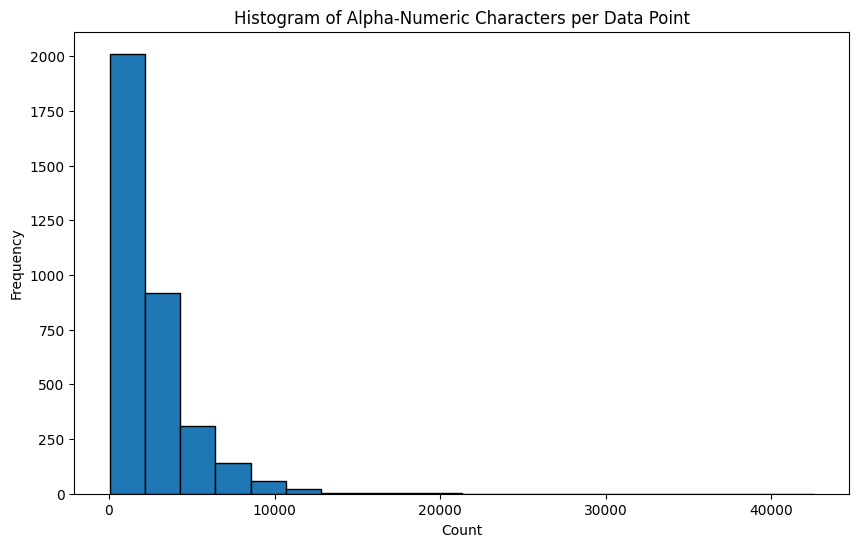

In [34]:
df['alpha_numeric_count'] = df['full_text'].apply(lambda x: sum(c.isalnum() for c in x))
plt.figure(figsize=(10, 6))
plt.hist(df['alpha_numeric_count'], bins=20, edgecolor='black')
plt.title('Histogram of Alpha-Numeric Characters per Data Point')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.show()

### Histograms (b)
Interpret plot:
- This histogram plots the column leaf label – class on the x-axis.
- From the graph below, we can see that the dataset is envenly distribited in the 'leaf_label' feature, which means the dataset is balanced. A balanced dataset ensures that each class is adequately represented, preventing overfitting and promoting better generalization to new, unseen data.

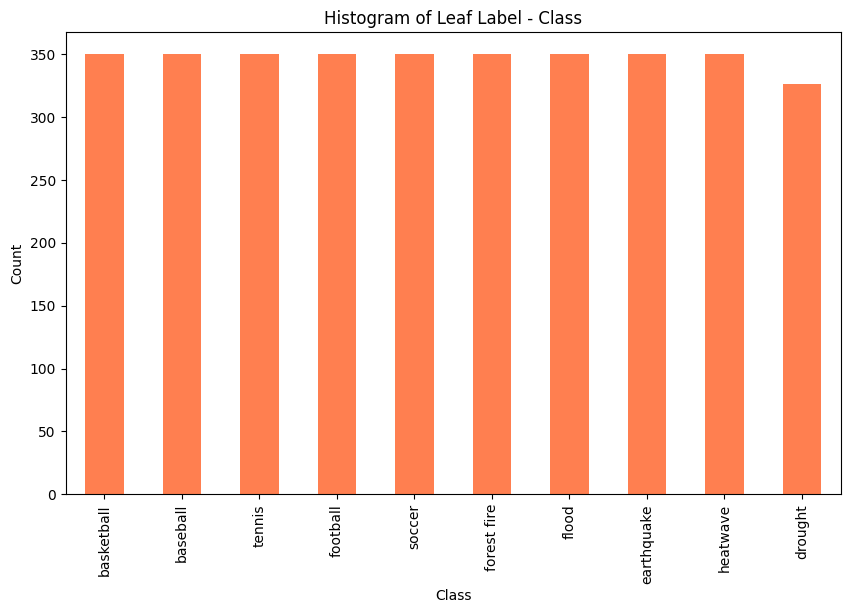

In [35]:

plt.figure(figsize=(10, 6))
df['leaf_label'].value_counts().plot(kind='bar', color='coral')
plt.title('Histogram of Leaf Label - Class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

### Histograms (c)
Interpret plot:
- This histogram plots the column root label – class on the x-axis.
- Similar to the leaf label histogram, we can see that the dataset is also envenly distribited in the 'root_label' feature, which means the dataset is balanced.


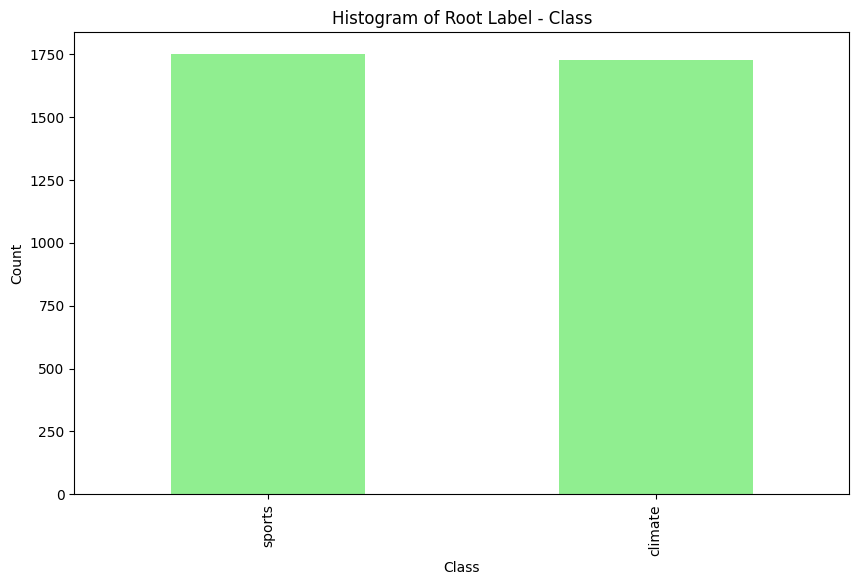

In [36]:

plt.figure(figsize=(10, 6))
df['root_label'].value_counts().plot(kind='bar', color='lightgreen')
plt.title('Histogram of Root Label - Class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


## QUESTION 2:
Answer: There are 2780 traing samples and 696 testing samples.

In [37]:
# code for Q2
print('The # of training samples:' , train.shape[0])
print('The # of testing samples:' , test.shape[0])

The # of training samples: 2780
The # of testing samples: 696


# 2. Feature Extraction

## Question 3 :

  Code and QA for Q3 is as below:

## 2.1 Cleaning

In [38]:
train['full_text']

2677    'While the four-day Aftershock's economic impa...
1204    'CBS Essentials is created independently of th...
2955    'Moderate-to-severe drought will likely contin...
2266    'Colleen Flood, the longtime co-owner of The F...
611     'WASHINGTON TRAFFIC MAY HAVE SAVED HIS LIFE. Y...
                              ...                        
1095    '(Photo by Justin Casterline/Getty Images)\n\n...
1130    'COOKEVILLE, Tenn. (WKRN) — The Golden Eagles ...
1294    'FanDuel Sportsbook has launched an exclusive ...
860     'Hunting stories are a Maine tradition, just l...
3174    'By Lewis Jackson\n\nSYDNEY (Reuters) -Thousan...
Name: full_text, Length: 2780, dtype: object

In [21]:
# Utils
import re

def clean(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ',texter)
    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    texter = re.sub(r'[^\w\s]', ' ', text) # Remove punctuation (keep spaces)
    texter = re.sub(r'\b\d+\b', ' ', texter) # add this line to exclude terms that are numbers (e.g. “123”, “-45”, “6.7” etc.)

    if texter == "":
        texter = ""
    return texter

In [40]:
# Clean

train['full_text_clean'] = train['full_text'].map(clean)
test['full_text_clean'] = test['full_text'].map(clean)

In [41]:
train['full_text_clean'].head(7)

2677     While the four day Aftershock s economic impa...
1204     CBS Essentials is created independently of th...
2955     Moderate to severe drought will likely contin...
2266     Colleen Flood  the longtime co owner of The F...
611      WASHINGTON TRAFFIC MAY HAVE SAVED HIS LIFE  Y...
3426     Last year  I made three predictions for what ...
3191     By Renju Jose\n\nSYDNEY  Reuters    Australia...
Name: full_text_clean, dtype: object

## 2.2 Apply lemmatization and stemming

Q3-1: What are the pros and cons of lemmatization versus stemming? How do these processes affect the dictionary size?
- Answer:
  - Lemmatizing
    - pros:
      1. Accuracy: Lemmatization tends to be more accurate.
      2. Lemmatization is preferred over stemming for NLP tasks where the precise meaning of words is crucial, such as keyword extraction and natural language generation.
    - cons:
      1. Inefficient: Lemmatization can be computationally more expensive than stemming.
      2. Complexity: Lemmatization involves a more complex approach compared to stemming. It considers the morphological structure of a word and employs a dictionary to associate various inflected forms of a word with its lemma.
  - Stemming
    - pros:
      1. Efficiency: The stemming approach is much faster than lemmatization.
      2. Simplicity: Stemming is a simpler process involving the removal of prefixes or suffixes to obtain a word stem.
    - cons:
      1. Less Accuracy: It's more crude and can occasionally lead to useless common base roots.
      2. Overstemming Problem: Stemming can sometimes lead to overstemming where words with different meanings are reduced to the same stem.
  - The experiment results below indicate that the original dictionary size for the full_text column is **40152**. Upon applying stemming, the dictionary size reduces to **36469**, demonstrating a decrease compared to the original size. Similarly, lemmatizing the full_text column results in a dictionary size of **36903**, which is smaller than the original size but slightly larger than the stemming method.

In [11]:
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# Lemmatizing
lemmatizer = WordNetLemmatizer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'

def lemmatize_sent(list_word):
    # Text input is string, returns array of lowercased strings(words).
    return [lemmatizer.lemmatize(word.lower(), pos=penn2morphy(tag))
            for word, tag in pos_tag(list_word)]

def lemmatize_text(text):
    tokens = text.split()
    lemmatized_tokens = lemmatize_sent(tokens)
    return ' '.join(lemmatized_tokens)

train['full_text_lemmatized'] = train['full_text_clean'].map(lemmatize_text)
test['full_text_lemmatized'] = test['full_text_clean'].map(lemmatize_text)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/knwng/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /Users/knwng/nltk_data...


NameError: name 'train' is not defined

In [43]:
print(train['full_text_lemmatized'][2955])

moderate to severe drought will likely continue to expand over the next several week a a dry weather pattern remain example video title will go here for this video charlotte n c over of north carolina be now at least some level of drought condition per the u s drought monitor this be the third consecutive fall and the fourth in the past five year in which part of western north carolina have severe drought condition severe drought in the carolina severe drought grow to for north carolina and over for south carolina accord to the drought monitor which be publish weekly on thursday in collaboration with usda noaa and others during a severe drought dry condition be grow quickly water conservation measure may also be implement for consumer and water system manager who may limit their downstream release or otherwise operate reservoir to hold onto more water such action be already underway with duke energy which use water from the catawba river basin include lake norman and lake wylie to prod

In [28]:
from nltk.stem import PorterStemmer

# Stemming
stemmer = PorterStemmer()

def stem_text(text):
    tokens = text.split()
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(stemmed_tokens)

train['full_text_stemmed'] = train['full_text_clean'].map(stem_text)
test['full_text_stemmed'] = test['full_text_clean'].map(stem_text)

Original Dictionary Size: 40048
Stemmed Dictionary Size: 27800
Lemmatized Dictionary Size: 32871


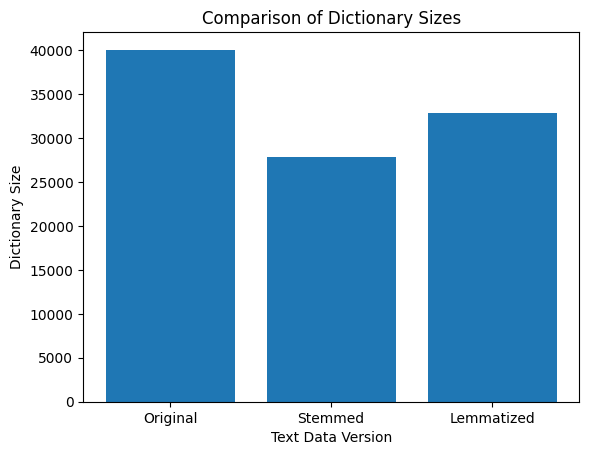

In [45]:
from sklearn.feature_extraction.text import CountVectorizer

# Experiment to compare the dictionary size
# Function to get dictionary size
def get_dict_size(text_data):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(text_data)
    dict_size = len(vectorizer.get_feature_names_out())
    return dict_size

# Original text data dictionary size
original_dict_size = get_dict_size(train['full_text'])

# Stemmed text data dictionary size
stemmed_dict_size = get_dict_size(train['full_text_stemmed'])

# Lemmatized text data dictionary size
lemmatized_dict_size = get_dict_size(train['full_text_lemmatized'])

# Print the results
print(f"Original Dictionary Size: {original_dict_size}")
print(f"Stemmed Dictionary Size: {stemmed_dict_size}")
print(f"Lemmatized Dictionary Size: {lemmatized_dict_size}")

# Data
versions = ['Original', 'Stemmed', 'Lemmatized']
dict_sizes = [original_dict_size, stemmed_dict_size, lemmatized_dict_size]

# Bar plot
plt.bar(versions, dict_sizes)
plt.xlabel('Text Data Version')
plt.ylabel('Dictionary Size')
plt.title('Comparison of Dictionary Sizes')
plt.show()

## 2.3 CountVectorizer


Q3-2: min_df means minimum document frequency. How does varying min_df change the TF-IDF matrix?
- Answer:
  - The experiment result below shows that as the min_df value increases, the size of the TF-IDF matrix decreases. This is expected because a higher min_df value excludes terms with lower document frequency, resulting in a sparser matrix.

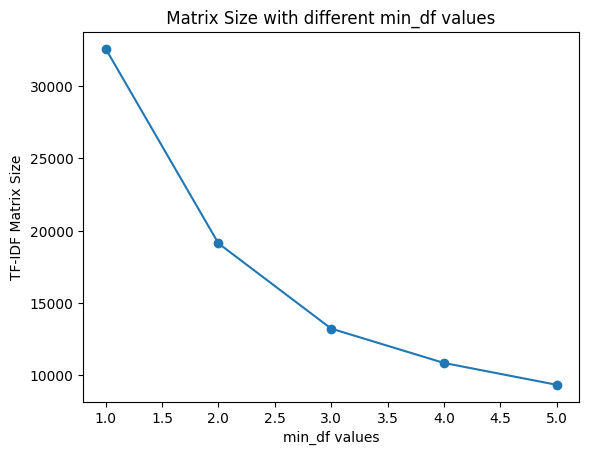

In [46]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

# Function to compare TF-IDF matrix with different min_df
def diff_min_df_compare(train, test, min_df_list):
    tfidf_matrix_shapes = []

    for min_df in min_df_list:
        vectorizer = CountVectorizer(min_df=min_df, stop_words='english')
        X_train_tfidf = vectorizer.fit_transform(train)
        X_test_tfidf = vectorizer.transform(test)
        tfidf_matrix_shapes.append(X_train_tfidf.shape)

    # Plot the changes in TF-IDF matrix size for different min_df values
    plt.plot(min_df_list, [shape[1] for shape in tfidf_matrix_shapes], marker='o')
    plt.xlabel('min_df values')
    plt.ylabel('TF-IDF Matrix Size')
    plt.title(' Matrix Size with different min_df values ')
    plt.show()

    return tfidf_matrix_shapes

min_df_values_to_test = [1, 2, 3, 4, 5]

tfidf_matrix_shapes_result = diff_min_df_compare(train['full_text_lemmatized'], test['full_text_lemmatized'], min_df_values_to_test)


In [47]:
train['full_text_lemmatized']

2677    while the four day aftershock s economic impac...
1204    cbs essential be create independently of the c...
2955    moderate to severe drought will likely continu...
2266    colleen flood the longtime co owner of the fou...
611     washington traffic may have saved his life yea...
                              ...                        
1095    photo by justin casterline getty image oan s j...
1130    cookeville tenn wkrn the golden eagle will hav...
1294    fanduel sportsbook have launch an exclusive pr...
860     hunt story be a maine tradition just like the ...
3174    by lewis jackson sydney reuters thousand of pe...
Name: full_text_lemmatized, Length: 2780, dtype: object

In [48]:
 test['full_text_lemmatized']

2069    a small patch of snow on the ground in douai i...
1425    antonio zago of brazil put on a jersey during ...
309     new york the la vega ace become the first team...
2270    christian abraham hearst connecticut medium ov...
3037    the city of watertown be currently under a wat...
                              ...                        
547     jasper tx today period of rain low 39f wind ne...
776     the atp final the final tennis championship of...
2873    boston the regulation direct how the state con...
2236    after week of infighting and turmoil that have...
568     state alabama alaska arizona arkansas californ...
Name: full_text_lemmatized, Length: 696, dtype: object

In [49]:
# set back to min_df = 3
vectorizer = CountVectorizer(min_df=3, stop_words='english') # min_df = 3 means "ignore terms that appear in less than 3 documents
X_train_counts = vectorizer.fit_transform(train['full_text_lemmatized'])
X_test_counts = vectorizer.transform(test['full_text_lemmatized'])


Q3-3: Should I remove stopwords before or after lemmatizing? Should I remove punctuations before or after lemmatizing? Should I remove numbers before or after lemmatizing? Hint: Recall that the full sentence is input into the Lemmatizer and the lemmatizer is tagging the position of every word based on the sentence structure.
- Answer:
  - Lemmatization depends on grammatical and syntactical structure of sentences. To optimize this process, it is advisable to remove **punctuation and numbers** before lemmatizing. This ensures that the lemmatizer concentrates on the actual words within the sentence structure.

  - Additionally, removing **stopwords** after lemmatization enables the lemmatizer to consider the remaining words in their more meaningful lemmatized form. This sequence enhances the preservation of semantic value when stopwords are removed after lemmatization.

## 2.4 TF-IDF


Q3-4: Report the shape of the TF-IDF-processed train and test matrices.
- Answer: Shape of the TF-IDF-processed train matrix is **(2780, 13240)** and the shape of the test matrix is **(696, 13240)** which match the results of Question 2.

In [69]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()

# recall that X_train_counts = count_vect.fit_transform(twenty_train.data)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
print('Shape of the TF-IDF-processed train matrix: ', X_train_tfidf.shape)
# X_test_tfidf = tfidf_transformer.fit_transform(X_test_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
print('Shape of the TF-IDF-processed test matrix: ', X_test_tfidf.shape)

Shape of the TF-IDF-processed train matrix:  (2780, 13240)
Shape of the TF-IDF-processed test matrix:  (696, 13240)


# 3. Dimensionality Reduction

## Question 4
 Code and QA for Q4 is as below:

## 3.2 LSI

Q4-1: Plot the explained variance ratio across multiple different k = [1, 10, 50, 100, 200, 500, 1000, 2000]. What does the explained variance ratio plot look like? What does the plot’s concavity suggest?
- Answer:
  - With an increasing number of components k, the explained variance ratio rises. The plot demonstrates a curve where the rate of increase gradually diminishes as additional components are incorporated.
  - Initially, with lower values of k, a small number of components significantly capture variance, resulting in a steep increase. However, as k increases, the rate of explained variance growth slows, indicating that the additional components contribute less to the total variance.
  - So we can conclude that beyond a certain point, adding more components has limited impact on capturing more information in the data. There is a trade-off between computation cost and explained variance.








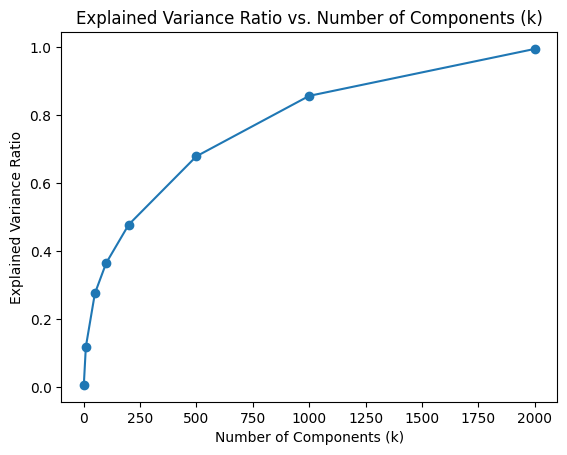

For k = 1, Explained Variance Ratio = 0.006675268215515366
For k = 10, Explained Variance Ratio = 0.11878865961568404
For k = 50, Explained Variance Ratio = 0.27560210071077534
For k = 100, Explained Variance Ratio = 0.364880989754092
For k = 200, Explained Variance Ratio = 0.4779556296968976
For k = 500, Explained Variance Ratio = 0.6788233560151331
For k = 1000, Explained Variance Ratio = 0.8565004133796812
For k = 2000, Explained Variance Ratio = 0.9945456172528205


In [51]:
from sklearn.decomposition import TruncatedSVD, randomized_svd

def plot_variance_ratio(X, k_values):
    variance_ratios = []

    for k in k_values:
        svd_model = TruncatedSVD(n_components=k, random_state=42)
        svd_model.fit(X)

        variance_ratio = np.sum(svd_model.explained_variance_ratio_)
        variance_ratios.append(variance_ratio)

    plt.plot(k_values, variance_ratios, marker='o')
    plt.xlabel('Number of Components (k)')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance Ratio vs. Number of Components (k)')
    plt.show()

    return variance_ratios

k_values_to_test = [1, 10, 50, 100, 200, 500, 1000, 2000]

explained_variance_ratios_result = plot_variance_ratio(X_train_tfidf, k_values_to_test)

for k, explained_variance_ratio in zip(k_values_to_test, explained_variance_ratios_result):
    print(f"For k = {k}, Explained Variance Ratio = {explained_variance_ratio}")

Q4-2: With k = 50 found in the previous sections, calculate the reconstruction residual MSE error when using LSI and NMF – they both should use the same k = 50. Which one is larger, the $\lVert X - WH \rVert_F^2$ in NMF or the $\lVert X−U_kΣ_kV^T_k\rVert^2_F$ in LSI and why?
- Answer:
<br> We obtaoined the following error values:

|                | LSI Error             | NMF Error             |
|----------------|-----------------------|-----------------------|
| **Training**   | 1947.6806148489693    | 1977.6471311260466    |
| **Testing**    | 464.19170092739245    | 519.6435904421344    |

  We observed that LSI error is lower than NMF error in both traing and testing scenario. This can be caused by the distinct mathematical formulations of LSI and NMF. LSI captures latent semantic relationships using singular value decomposition, allowing it to better represent the higher-dimensional feature matrix with lower information loss. On the other hand, NMF is restricted by obtaining only non-negative factors ($W ≥ 0$ and $H ≥ 0$)to represent the data.


In [52]:
# set back to k = 50, for the rest sections
svd = TruncatedSVD(n_components=50, random_state=42)
X_train_reduced = svd.fit_transform(X_train_tfidf)
U_tr,S_tr,V_tr = randomized_svd(X_train_tfidf,n_components=50,random_state=42)
print('LSI train error:', np.sum(np.array(X_train_tfidf - (U_tr.dot(np.diag(S_tr)).dot(V_tr)))**2))
test_data_LSI = svd.transform(X_test_tfidf)
U_te,S_te,V_te = randomized_svd(X_test_tfidf,n_components=50,random_state=42)
print('LSI test error:', np.sum(np.array(X_test_tfidf - (U_te.dot(np.diag(S_te)).dot(V_te)))**2))


LSI train error: 1947.6806148489693
LSI test error: 464.19170092739245


## 3.1 NMF

In [ ]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=50, init='random', random_state=42)
W_train = nmf.fit_transform(X_train_tfidf)
H = nmf.components_
print('NMF train error:', np.sum(np.array(X_train_tfidf - W_train.dot(H))**2))
# W_test = nmf.fit_transform(X_test_tfidf)
W_test = nmf.transform(X_test_tfidf)
H = nmf.components_
print('NMF test error:', np.sum(np.array(X_test_tfidf - W_test.dot(H))**2))


NMF train error: 1977.6471311260466
NMF test error: 519.6435904421344


# 4. Classification Algorithms

## ROC

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def plot_roc(fpr, tpr):
    fig, ax = plt.subplots()

    roc_auc = auc(fpr,tpr)

    ax.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)

    ax.grid(color='0.7', linestyle='--', linewidth=1)

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.set_ylabel('True Positive Rate',fontsize=15)

    ax.legend(loc="lower right")

    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(15)

def fit_predict_and_plot_roc(pipe, train_data, train_label, test_data, test_label):
    pipe.fit(train_data, train_label)
    # pipeline1.predict(twenty_test.data)

    if hasattr(pipe, 'decision_function'):
        prob_score = pipe.decision_function(test_data)
        fpr, tpr, _ = roc_curve(test_label, prob_score)
    else:
        prob_score = pipe.predict_proba(test_data)
        fpr, tpr, _ = roc_curve(test_label, prob_score[:,1])

    plot_roc(fpr, tpr)
#     return pipe

## Linear SVM

### Question 5
Q5-1: Compare and contrast hard-margin and soft-margin linear SVMs:

- Q: Train one SVM with $\gamma$ = 1000 (hard margin), another with $\gamma$ = 0.0001 (soft margin). Which one performs better? What about for $\gamma$ = 100000?
  - A: Performance: $\gamma$ = 1000 (acc: 0.955481) > $\gamma$ = 100000 (acc: 0.943835) > $\gamma$ = 0.0001 (acc: 0.918029)
- Q: What happens for the soft margin SVM? Why is the case? Analyze in terms of the confusion matrix.
  - A: Soft margin SVM allow SVM to make a certain number of mistakes and keep margin as wide as possible so that other points can still be classified correctly. According to the confusion matrix, the soft margin SVM performs poorly where it misclassifies many class "sports" as class "climate", resulting in low sports recall and low climate precision.
- Q: Does the ROC curve reflect the performance of the soft-margin SVM? Why?
  - A: According to the ROC curve, the model's True Positive Rate (TPR) gradually increases as the False Positive Rate (FPR) rises. This contrasts with hard-margin SVM, which typically exhibits a sharp rise at the beginning of the curve. This aligns with our observation of the model's low sports recall.

Below paragraphs are the ROC curve, the confusion matrix, and the accuracy, recall, precision and F-1 score of SVM classifiers on the testing set.

### SVM - gamma = 1000 (f1-score: 0.955481)

In [ ]:
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [ ]:
clf = make_pipeline(LinearSVC( C=1000,random_state=42))
clf.fit(X_train_reduced, train['root_label'])
y_pred_LSI = clf.predict(test_data_LSI)

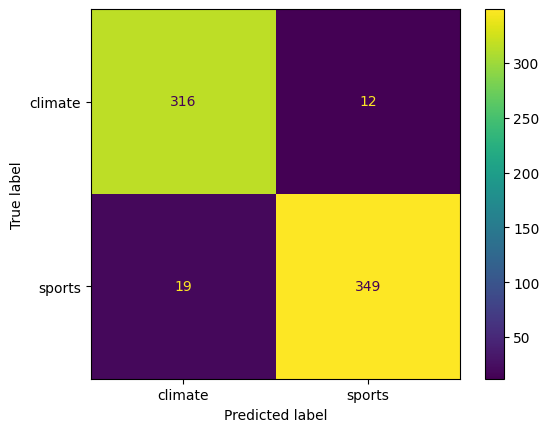

In [ ]:
cm = confusion_matrix(test['root_label'], y_pred_LSI, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

In [ ]:
print(classification_report(test['root_label'], y_pred_LSI, target_names=["climate", "sports"], digits=6))

              precision    recall  f1-score   support

     climate   0.943284  0.963415  0.953243       328
      sports   0.966759  0.948370  0.957476       368

    accuracy                       0.955460       696
   macro avg   0.955021  0.955892  0.955359       696
weighted avg   0.955696  0.955460  0.955481       696



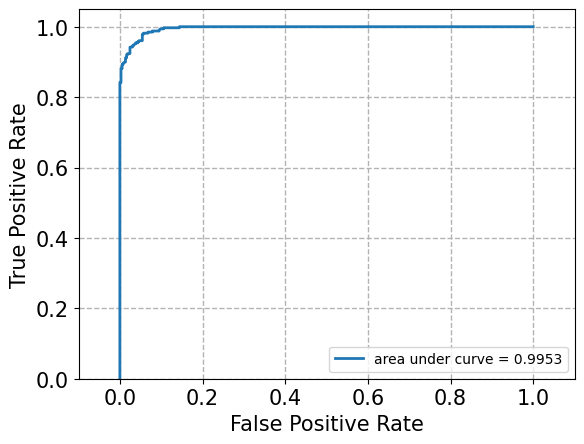

In [ ]:
fit_predict_and_plot_roc(clf, X_train_reduced, [0 if i == "sports" else 1 for i in train['root_label']], test_data_LSI, [0 if i == "sports" else 1 for i in test['root_label']])

### SVM - gamma = 0.0001 (f1-score: 0.918029)

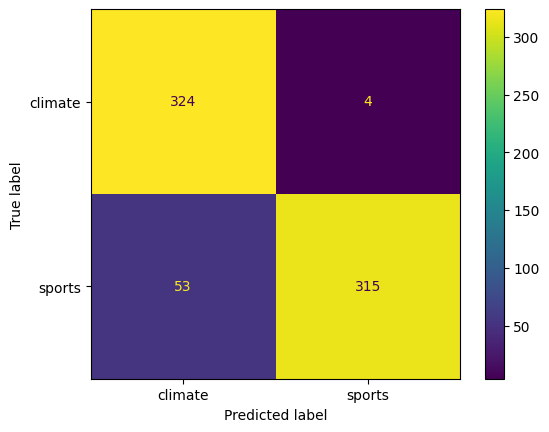

In [ ]:
clf = make_pipeline(LinearSVC(C=.0001, random_state=42))
clf.fit(X_train_reduced, train['root_label'])
y_pred_LSI = clf.predict(test_data_LSI)
cm = confusion_matrix(test['root_label'], y_pred_LSI, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

In [ ]:
print(classification_report(test['root_label'], y_pred_LSI, target_names=["climate", "sports"], digits=6))

              precision    recall  f1-score   support

     climate   0.859416  0.987805  0.919149       328
      sports   0.987461  0.855978  0.917031       368

    accuracy                       0.918103       696
   macro avg   0.923439  0.921892  0.918090       696
weighted avg   0.927118  0.918103  0.918029       696



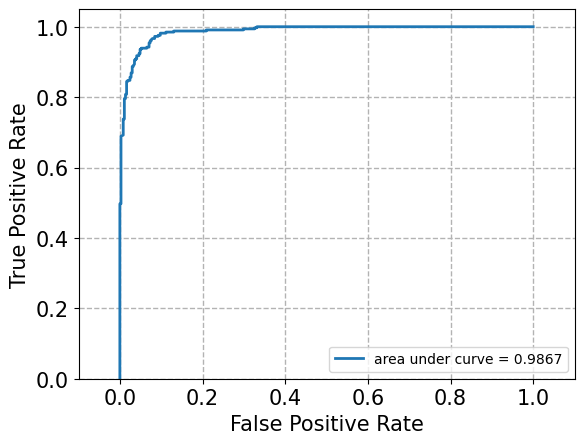

In [ ]:
fit_predict_and_plot_roc(clf, X_train_reduced, [0 if i == "sports" else 1 for i in train['root_label']], test_data_LSI, [0 if i == "sports" else 1 for i in test['root_label']])

### SVM - gamma = 100000 (f1-score: 0.943835)

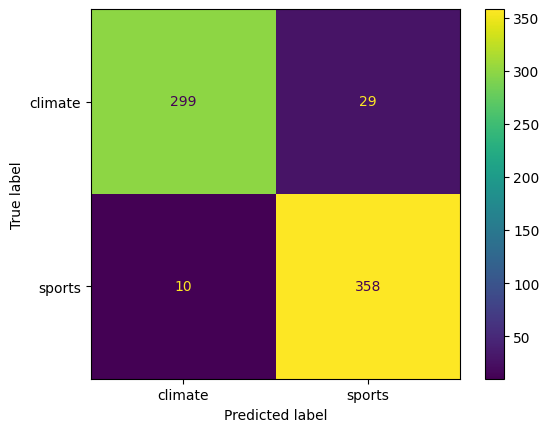

In [ ]:
clf = make_pipeline(LinearSVC(C=100000, random_state=42))
clf.fit(X_train_reduced, train['root_label'])
y_pred_LSI = clf.predict(test_data_LSI)
cm = confusion_matrix(test['root_label'], y_pred_LSI, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

In [ ]:
print(classification_report(test['root_label'], y_pred_LSI, target_names=["climate", "sports"], digits=6))

              precision    recall  f1-score   support

     climate   0.967638  0.911585  0.938776       328
      sports   0.925065  0.972826  0.948344       368

    accuracy                       0.943966       696
   macro avg   0.946351  0.942206  0.943560       696
weighted avg   0.945128  0.943966  0.943835       696



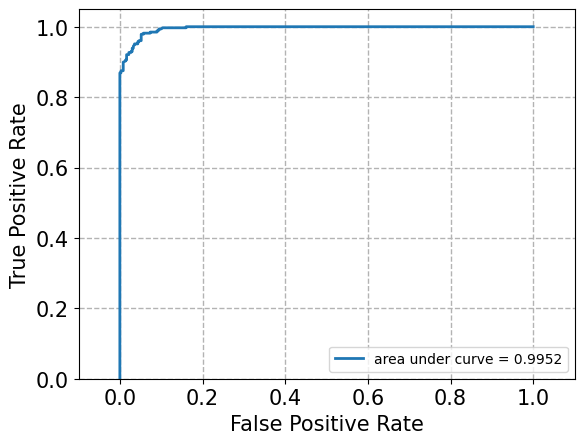

In [ ]:
fit_predict_and_plot_roc(clf, X_train_reduced, [0 if i == "sports" else 1 for i in train['root_label']], test_data_LSI, [0 if i == "sports" else 1 for i in test['root_label']])

### Q5-2: Use cross-validation to choose $\gamma$ (use average validation 3 accuracy to compare):

Q: Using a 5-fold cross-validation, find the best value of the parameter $\gamma$ in the range {10k| − 3 ≤ k ≤ 6,k ∈ Z}.

A: As shown in the figure below, through cross-validation, we identified the best SVM configuration with $\gamma$ = 10, achieving f1-score, precision and recall of 0.956897.


  |precision  |  recall|  f1-score |
  |--------|--------|--------|
  |0.956897|  0.956897 | 0.956897|

### SVM - cross validation

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

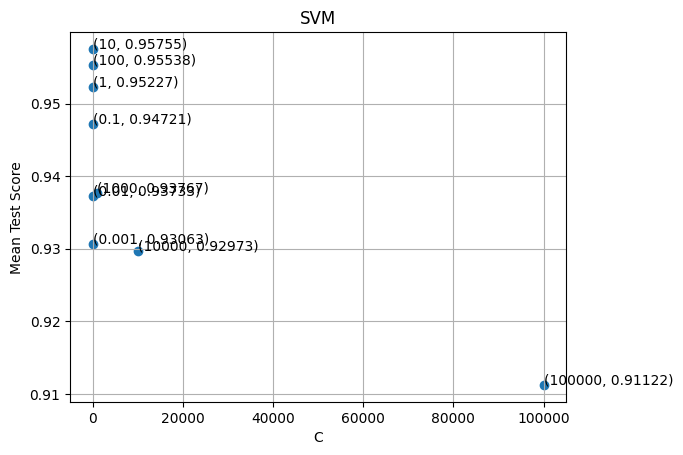

In [ ]:
mean_test_score = []
for i in range(-3,6):
  gamma = 10 ** i

  clf = make_pipeline(LinearSVC(C=gamma,random_state=42))
  cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=42)
  scores = cross_val_score(clf, X_train_reduced, train['root_label'], cv=cv, scoring='f1_macro')
  # print(f'{gamma=}, avg scores: {np.mean(scores)}')

  mean_test_score.append(np.mean(scores))


x = [10 ** i for i in range(-3, 6)]
y = mean_test_score
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(x,y)
for xy in zip(x, y):
    ax.annotate('(%s, %.5f)' % xy, xy=xy, textcoords='data')
plt.xlabel('C'); plt.ylabel('Mean Test Score'); plt.title("SVM")
plt.grid()

Q5-2: ROC curve, confusion matrix and the accuracy, recall, precision and F-1 score of this best SVM in the following paragraphs:

gamma: 10


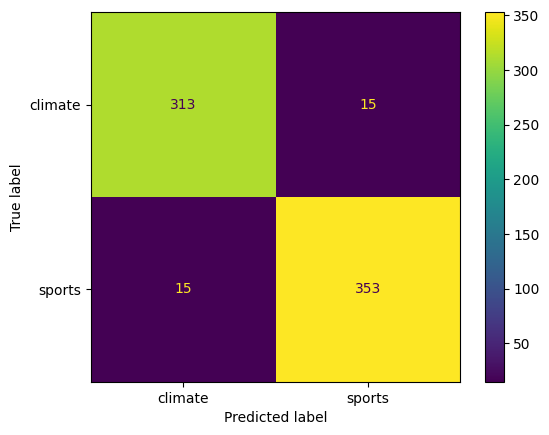

In [ ]:
gamma = 10
clf = make_pipeline(LinearSVC(C=gamma, random_state=42))
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=42)
scores = cross_val_score(clf, X_train_reduced, train['root_label'], cv=cv, scoring='f1_macro')
print(f"gamma: {gamma}")

# predict
clf.fit(X_train_reduced, train['root_label'])
y_pred_LSI = clf.predict(test_data_LSI)
cm = confusion_matrix(test['root_label'], y_pred_LSI, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

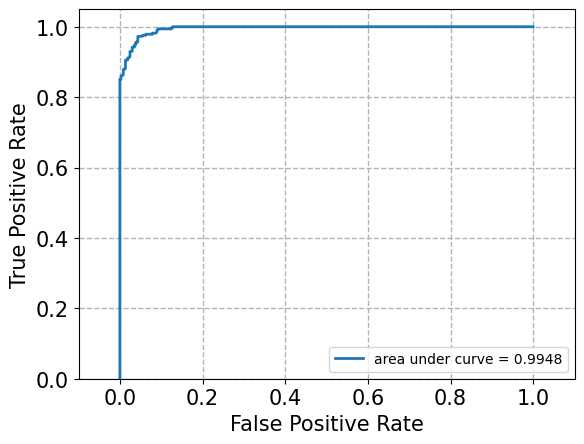

In [ ]:
fit_predict_and_plot_roc(clf, X_train_reduced, [0 if i == "sports" else 1 for i in train['root_label']], test_data_LSI, [0 if i == "sports" else 1 for i in test['root_label']])

In [ ]:
print(classification_report(test['root_label'], y_pred_LSI, target_names=["climate", "sports"], digits=6))

              precision    recall  f1-score   support

     climate   0.954268  0.954268  0.954268       328
      sports   0.959239  0.959239  0.959239       368

    accuracy                       0.956897       696
   macro avg   0.956754  0.956754  0.956754       696
weighted avg   0.956897  0.956897  0.956897       696



## Logistic Classifier

### Question 6
Evaluate a logistic classifier

- Q: Compare the performance (accuracy, precision, recall and F-1 score) of 3 logistic classifiers: w/o regularization, w/ L1 regularization and w/ L2 regularization (with the best parameters you found from the part above), using test data.
  - Performance: w/o regularization (acc: 0.958337) > w/ L1 regularization with with regularization strength = 100 (acc: 0.956897) == w/ L2 regularization with regularization strength = 100 (acc: 0.956897)
  - However, the three classifiers seemed neck-and-neck in performance. According to the confusion matrix, it revealed only a single data point difference, which is a "climate" instance was misclassified as "sports".
- Q: How does the regularization parameter affect the test error? How are the learnt coefficients affected? Why might one be interested in each type of regularization?
  - Adding any regularization will increase the error on training set. This is exactly the point of the regularization, where we increase bias and reduce the variance of the model.
  - As the printed coefficients below, we can see how the penalty parameter's weight affects them. For example, the coefficients of the logistic classifier without any penalty are pretty similar to those with L1. However, the coefficients of classifier with L2 penalty is quite different.
- Q: Both logistic regression and linear SVM are trying to classify data points using a linear decision boundary. What is the difference between their ways to find this boundary? Why do their performances differ? Is this difference statistically significant?
  - Logistic regression uses all the data points to find the decision boundary. However, linear SVM only uses a small subset of the data points called the support vectors to find the decision boundary.


Below paragraphs are the ROC curve, the confusion matrix, and the accuracy, recall, precision and F-1 score of logistic classifier on the testing set.

### Logistic Classifier without penalty (f1-score: 0.958337)

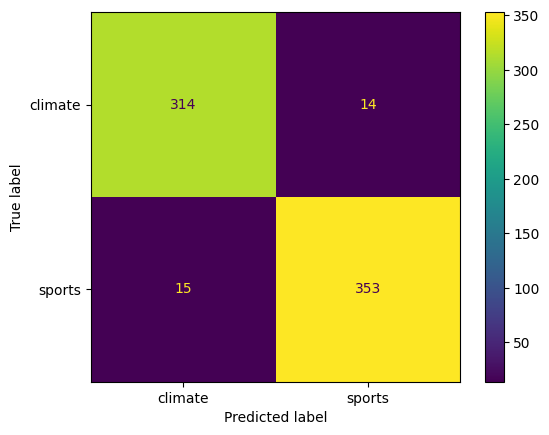

              precision    recall  f1-score   support

     climate   0.954407  0.957317  0.955860       328
      sports   0.961853  0.959239  0.960544       368

    accuracy                       0.958333       696
   macro avg   0.958130  0.958278  0.958202       696
weighted avg   0.958344  0.958333  0.958337       696



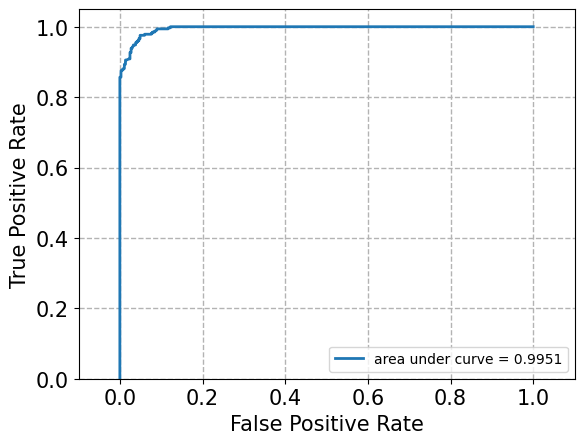

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression('none', solver='saga')
clf.fit(X_train_reduced, train['root_label'])
y_pred_LSI = clf.predict(test_data_LSI)
cm = confusion_matrix(test['root_label'], y_pred_LSI, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()
print(classification_report(test['root_label'], y_pred_LSI, target_names=["climate", "sports"], digits=6))
fit_predict_and_plot_roc(clf, X_train_reduced, [0 if i == "sports" else 1 for i in train['root_label']], test_data_LSI, [0 if i == "sports" else 1 for i in test['root_label']])

In [ ]:
print(f'Coefficients learned by logistic regression with no regularization: \n{clf.coef_}')

Coefficients learned by logistic regression with no regularization: 
[[ 20.13593084  32.86144487 -51.68710209  21.0604478    1.60458876
   -1.72879056 -33.98138001  13.26010844   5.75050993   4.76054654
  -20.67969796  -1.38434363  -8.96120336   5.07362569 -12.66284508
    2.01009488   6.03681858   9.77689964   9.70197567   5.88959188
   -2.54734566  -8.26511308  19.72652716  -1.01188827  -2.26393491
  -13.00382999  13.02212756  21.12060226  -9.93194839   0.60101568
   -2.01501942  -5.86820953  -9.43031602 -10.11156558   7.85671505
   -6.22798591   7.8465804    1.41994507  -4.94788395   7.39113954
    7.59673385 -15.8339565    8.91692909   4.45384153  -6.48984785
   -3.29379342 -19.96461762  -7.39803656  -3.2525961   -3.30082677]]


### Logistic Classifier with L1 penalty with regularization strength = 100 (f1-score: 0.956897)

In [ ]:
# Cross Validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

for k in range(-5,6):
  strength = 10**k

  clf = make_pipeline(LogisticRegression('l1', solver='saga', C=strength))
  cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=42)
  scores = cross_val_score(clf, X_train_reduced, train['root_label'], cv=cv, scoring='f1_macro')
  print(f'{strength=}, avg scores: {np.mean(scores)}')

strength=1e-05, avg scores: 0.3309682982655582
strength=0.0001, avg scores: 0.3326737358155136
strength=0.001, avg scores: 0.3309682982655582
strength=0.01, avg scores: 0.33224734373486575
strength=0.1, avg scores: 0.9258896234268634
strength=1, avg scores: 0.9450791779068176
strength=10, avg scores: 0.9568264380725203
strength=100, avg scores: 0.957064791589692
strength=1000, avg scores: 0.9568253427067196
strength=10000, avg scores: 0.9568253427067196
strength=100000, avg scores: 0.957064791589692


Classify using LogisticRegression with l1 regularization strength 100


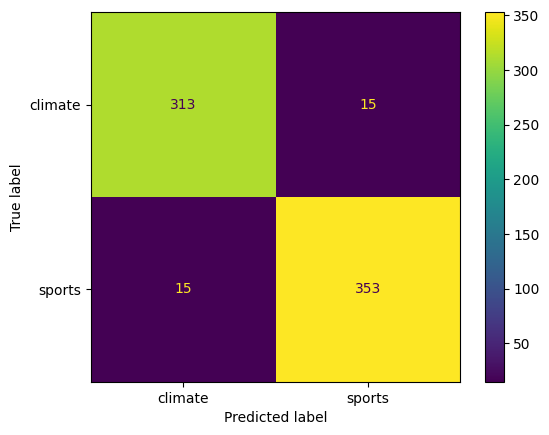

              precision    recall  f1-score   support

     climate   0.954268  0.954268  0.954268       328
      sports   0.959239  0.959239  0.959239       368

    accuracy                       0.956897       696
   macro avg   0.956754  0.956754  0.956754       696
weighted avg   0.956897  0.956897  0.956897       696



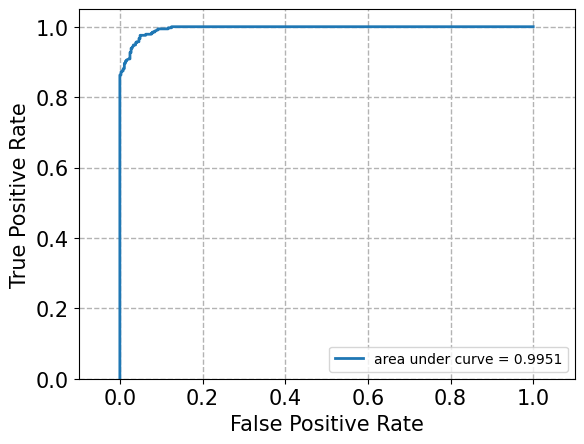

In [ ]:
from sklearn.linear_model import LogisticRegression

strength = 100
print(f'Classify using LogisticRegression with l1 regularization strength {strength}')
clf = LogisticRegression('l1', solver='saga', C=strength)
clf.fit(X_train_reduced, train['root_label'])
y_pred_LSI = clf.predict(test_data_LSI)
cm = confusion_matrix(test['root_label'], y_pred_LSI, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()
print(classification_report(test['root_label'], y_pred_LSI, target_names=["climate", "sports"], digits=6))
fit_predict_and_plot_roc(clf, X_train_reduced, [0 if i == "sports" else 1 for i in train['root_label']], test_data_LSI, [0 if i == "sports" else 1 for i in test['root_label']])

In [ ]:
print(f'Coefficients learned by logistic regression with l1 regularization: \n{clf.coef_}')

Coefficients learned by logistic regression with l1 regularization: 
[[ 19.40436196  31.9096549  -51.17247785  20.59947153   1.51125653
   -1.23404379 -33.72969202  12.7853978    5.21476804   4.65791393
  -20.30401986  -1.04555823  -8.67240917   4.9380801  -12.48423368
    1.92425405   5.64019151   9.59728377   9.35656425   5.64023431
   -2.50395578  -7.90792497  19.13009384  -0.54944236  -2.19856273
  -12.60718286  12.47412773  20.37984959  -9.61252662   0.26599551
   -2.02659128  -5.05314944  -9.05207584  -9.96757025   7.76907895
   -6.13706634   7.75735932   1.03517651  -4.52374275   7.03649487
    7.22855857 -15.38220711   8.53425964   4.21820573  -6.16593339
   -2.93489194 -19.31342212  -7.49080641  -2.95837871  -3.13130889]]


### Logistic Classifier with L2 penalty with regularization strength = 100 (f1-score: 0.956897)

In [ ]:
# cross validation

for k in range(-5,6):
  strength = 10**k

  clf = make_pipeline(LogisticRegression('l2',  solver='saga',  C=strength))
  cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=42)
  scores = cross_val_score(clf, X_train_reduced, train['root_label'], cv=cv, scoring='f1_macro')
  print(f'{strength=}, avg scores: {np.mean(scores)}')
  # max strength = 100

strength=1e-05, avg scores: 0.44029352882622597
strength=0.0001, avg scores: 0.44572297717984694
strength=0.001, avg scores: 0.6727817368311308
strength=0.01, avg scores: 0.9301214929433665
strength=0.1, avg scores: 0.9380555377864603
strength=1, avg scores: 0.9484171313939171
strength=10, avg scores: 0.9541889505283556
strength=100, avg scores: 0.957305623231752
strength=1000, avg scores: 0.957064791589692
strength=10000, avg scores: 0.957064791589692
strength=100000, avg scores: 0.957064791589692


Classify using LogisticRegression with l2 regularization strength 100


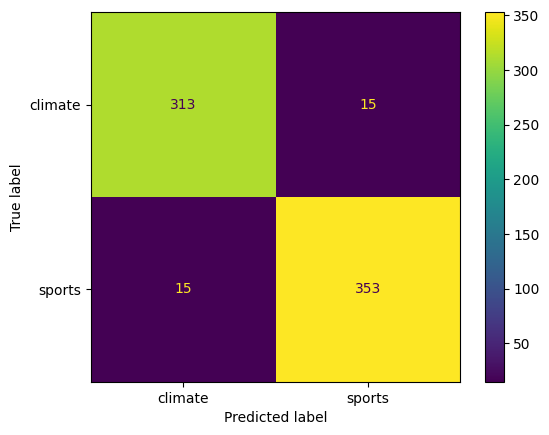

              precision    recall  f1-score   support

     climate   0.954268  0.954268  0.954268       328
      sports   0.959239  0.959239  0.959239       368

    accuracy                       0.956897       696
   macro avg   0.956754  0.956754  0.956754       696
weighted avg   0.956897  0.956897  0.956897       696



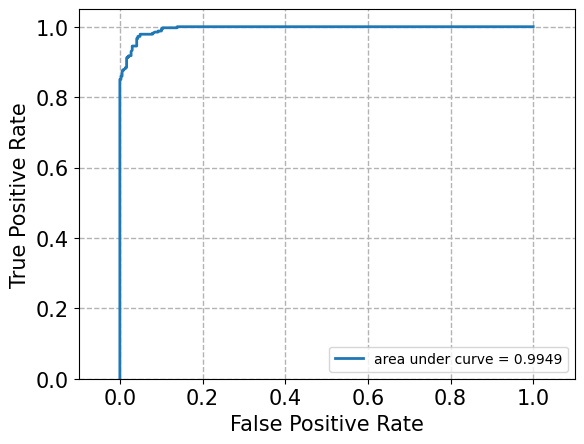

In [ ]:
strength = 100
print(f'Classify using LogisticRegression with l2 regularization strength {strength}')
clf = LogisticRegression('l2', solver='saga', C=strength)
clf.fit(X_train_reduced, train['root_label'])
y_pred_LSI = clf.predict(test_data_LSI)
cm = confusion_matrix(test['root_label'], y_pred_LSI, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()
print(classification_report(test['root_label'], y_pred_LSI, target_names=["climate", "sports"], digits=6))
fit_predict_and_plot_roc(clf, X_train_reduced, [0 if i == "sports" else 1 for i in train['root_label']], test_data_LSI, [0 if i == "sports" else 1 for i in test['root_label']])

In [ ]:
print(f'Coefficients learned by logistic regression with l2 regularization: \n{clf.coef_}')

Coefficients learned by logistic regression with l2 regularization: 
[[ 13.7769947   24.48153516 -41.99767098  15.59569436   1.47016719
   -1.25683858 -22.69827586   9.87408287   2.36725546   6.62046166
  -16.14621804   0.08090801  -7.19604655   4.49675304 -10.01488885
    0.89943998   4.22885154   6.597363     8.27822584   5.19446447
   -2.13791708  -5.95281138  13.73961265  -1.28504439  -2.24109545
   -9.68407812   9.98375708  13.80512062  -6.69417791   0.68701953
   -1.84319055  -3.91083883  -5.73676183  -8.12343742   6.74569744
   -5.16212145   5.93056044   0.7825228   -3.39975351   5.579964
    5.30034627 -11.28343303   5.66015702   3.49729728  -4.89026885
   -2.66645729 -13.65750854  -6.74836789  -2.24069733  -2.23719311]]


## Naive Bayes Classifier

### Question 7
Q7: Evaluate and profile a Naive Bayes classifier:
- Compared to linear SVM and logistic regression, Naive Bayes is the worst performer of the three classifiers. This is likely because its underlying assumption is that all variables are independent, but textual datasets clearly show that some words often co-occur.
- Below paragraphs are the ROC curve, the confusion matrix, and the accuracy, recall, precision and F-1 score of Naive Bayes classifier on the testing set.

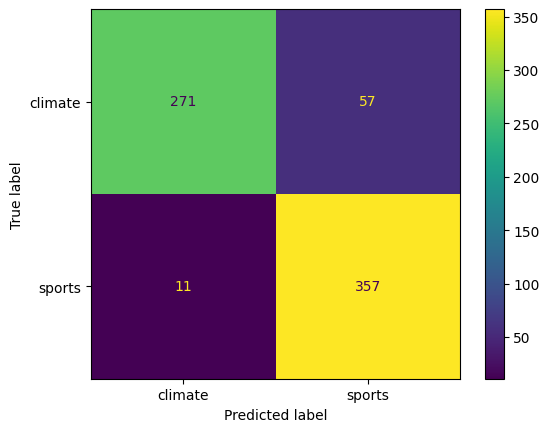

In [ ]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X_train_reduced, train['root_label'])
y_pred_LSI = clf.predict(test_data_LSI)
cm = confusion_matrix(test['root_label'], y_pred_LSI, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

In [ ]:
print(classification_report(test['root_label'], y_pred_LSI, target_names=["climate", "sports"], digits=6))

              precision    recall  f1-score   support

     climate   0.960993  0.826220  0.888525       328
      sports   0.862319  0.970109  0.913043       368

    accuracy                       0.902299       696
   macro avg   0.911656  0.898164  0.900784       696
weighted avg   0.908820  0.902299  0.901489       696



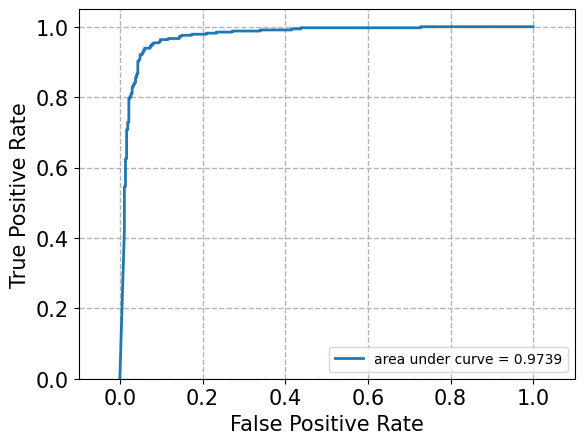

In [ ]:
fit_predict_and_plot_roc(clf, X_train_reduced, [0 if i == "sports" else 1 for i in train['root_label']], test_data_LSI, [0 if i == "sports" else 1 for i in test['root_label']])

# 5. Grid Search

## Question 8

In this part, you will attempt to find the best model for binary classification.
- Construct a Pipeline that performs feature extraction, dimensionality reduction and classification;
- The evaluation of each combination is performed with 5-fold cross-validation (use the average validation set accuracy across folds).
- In addition to any other hyperparameters you choose, your gridsearch must at least include:
- What are the 5 best combinations? Report their performances on the testing set.

Answer:

Top 5 combinations:

| Rank | Vocabulation Compilation | min_df | Dim Reduction | n_components | Classifier | LR penalty | Average Validation Accuracy | Accuracy on Testing Set |
| :----: | :----: | :----: | :----: | :----: | :----: | :----: | :----: | :----: |
| 1 | lemmatization | 5 | TruncatedSVD | 80 | LogisticRegression | l2 | 95.32% | 94.40% |
| 2 | stemming | 5 | TruncatedSVD | 80 | LogisticRegression | l2 | 95.22% | 95.26% |
| 3 | stemming | 3 | TruncatedSVD | 80 | LogisticRegression | l2 | 95.14% | 95.40% |
| 4 | lemmatization | 3 | NMF | 80 | GaussianNB | | 95.14% | 94.83% |
| 5 | stemming | 5 | NMF | 80 | GaussianNB | | 95.07% | 94.40% |

The code for grid search is shown below.

In [25]:
%%capture
# %matplotlib inline

# Setup Env
!pip install joblib matplotlib

import joblib

import sys
import multiprocessing as mp
sys.modules['sklearn.externals.joblib'] = joblib

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import FunctionTransformer

# used to cache results
from tempfile import mkdtemp
from shutil import rmtree
from sklearn.externals.joblib import Memory

cachedir = mkdtemp()
memory = Memory(cachedir, verbose=10)

def lemmatize_all(data):
  return data.map(lemmatize_text)

def stem_all(data):
  return data.map(stem_text)

lemmatize_transformer = FunctionTransformer(lemmatize_all)
stem_transformer = FunctionTransformer(stem_all)

pipeline = Pipeline([
    ('stem_or_lemmatize', lemmatize_transformer),
    ('vect', CountVectorizer(min_df=1, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(random_state=0)),
    ('clf', GaussianNB()),
], memory=memory)

N_FEATURES_OPTIONS = [5, 30, 80]
C_OPTIONS = [0.1, 1, 10]

param_grid = [
    {
        'stem_or_lemmatize': [stem_transformer, lemmatize_transformer], # 2 choices
        'vect__min_df': [3, 5], # 2 choices
        'reduce_dim': [TruncatedSVD(), NMF()], # 2 choices
        'reduce_dim__n_components': N_FEATURES_OPTIONS, # 3 choices
        'clf': [SVC(gamma=0.1, kernel='linear'), GaussianNB()], # 2 choices
        # 48 choices
    },
    {
        'stem_or_lemmatize': [stem_transformer, lemmatize_transformer], # 2 choices
        'vect__min_df': [3, 5], # 2 choices
        'reduce_dim': [TruncatedSVD(), NMF()], # 2 choices
        'reduce_dim__n_components': N_FEATURES_OPTIONS, # 3 choices
        'clf': [LogisticRegression()], # 1 choice
        'clf__penalty': ['l1', 'l2'], # 2 choices
        # 48 choices
    },
    # 96 choices in total
]

grid = GridSearchCV(pipeline, cv=5, n_jobs=1, param_grid=param_grid, scoring='accuracy')

train['full_text'] = train['full_text'].map(clean)
test['full_text'] = test['full_text'].map(clean)

print('Start to grid search...')
grid.fit(train['full_text'], train['root_label'])
rmtree(cachedir)


In [26]:
import pandas as pd

# pd.set_option('display.max_columns', 500)
# pd.set_option('display.max_rows', 500)

pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf,param_reduce_dim,param_reduce_dim__n_components,param_stem_or_lemmatize,param_vect__min_df,param_clf__penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.056145,0.001728,0.000000,0.000000,"SVC(gamma=0.1, kernel='linear')",TruncatedSVD(),5,FunctionTransformer(func=<function stem_all at...,3,NaN,"{'clf': SVC(gamma=0.1, kernel='linear'), 'redu...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,37
1,0.056852,0.005319,0.000000,0.000000,"SVC(gamma=0.1, kernel='linear')",TruncatedSVD(),5,FunctionTransformer(func=<function stem_all at...,5,NaN,"{'clf': SVC(gamma=0.1, kernel='linear'), 'redu...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,37
2,38.826335,2.310739,9.095541,0.580230,"SVC(gamma=0.1, kernel='linear')",TruncatedSVD(),5,FunctionTransformer(func=<function lemmatize_a...,3,NaN,"{'clf': SVC(gamma=0.1, kernel='linear'), 'redu...",0.911871,0.913669,0.926259,0.919065,0.933453,0.920863,0.008043,29
3,0.888633,0.051235,9.057320,0.357225,"SVC(gamma=0.1, kernel='linear')",TruncatedSVD(),5,FunctionTransformer(func=<function lemmatize_a...,5,NaN,"{'clf': SVC(gamma=0.1, kernel='linear'), 'redu...",0.908273,0.910072,0.928058,0.919065,0.935252,0.920144,0.010338,31
4,0.048339,0.002899,0.000000,0.000000,"SVC(gamma=0.1, kernel='linear')",TruncatedSVD(),30,FunctionTransformer(func=<function stem_all at...,3,NaN,"{'clf': SVC(gamma=0.1, kernel='linear'), 'redu...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,0.127955,0.004593,8.680813,0.483313,LogisticRegression(),NMF(),30,FunctionTransformer(func=<function lemmatize_a...,5,l2,"{'clf': LogisticRegression(), 'clf__penalty': ...",0.944245,0.938849,0.944245,0.933453,0.947842,0.941727,0.005036,16
92,0.051442,0.005753,0.000000,0.000000,LogisticRegression(),NMF(),80,FunctionTransformer(func=<function stem_all at...,3,l2,"{'clf': LogisticRegression(), 'clf__penalty': ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,37
93,0.044640,0.004760,0.000000,0.000000,LogisticRegression(),NMF(),80,FunctionTransformer(func=<function stem_all at...,5,l2,"{'clf': LogisticRegression(), 'clf__penalty': ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,37
94,0.129473,0.001020,8.499250,0.201780,LogisticRegression(),NMF(),80,FunctionTransformer(func=<function lemmatize_a...,3,l2,"{'clf': LogisticRegression(), 'clf__penalty': ...",0.935252,0.949640,0.953237,0.935252,0.955036,0.945683,0.008693,10


In [29]:
# Test using top 5 combination

combinations = [
  # 1st
  [
    ('stem_or_lemmatize', lemmatize_transformer),
    ('vect', CountVectorizer(min_df=5, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(random_state=0, n_components=80)),
    ('clf', LogisticRegression(penalty='l2'))
  ],
  # 2nd
  [
    ('stem_or_lemmatize', stem_transformer),
    ('vect', CountVectorizer(min_df=5, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(random_state=0, n_components=80)),
    ('clf', LogisticRegression(penalty='l2'))
  ],
  # 3rd
  [
    ('stem_or_lemmatize', stem_transformer),
    ('vect', CountVectorizer(min_df=3, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(random_state=0, n_components=80)),
    ('clf', LogisticRegression(penalty='l2'))
  ],
  # 4th
  [
    ('stem_or_lemmatize', lemmatize_transformer),
    ('vect', CountVectorizer(min_df=3, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', NMF(random_state=0, n_components=80)),
    ('clf', GaussianNB())
  ],
  # 5th
  [
    ('stem_or_lemmatize', stem_transformer),
    ('vect', CountVectorizer(min_df=5, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', NMF(random_state=0, n_components=80)),
    ('clf', GaussianNB())
  ]
]

for i, combination in enumerate(combinations):
  pipeline = Pipeline(combination)
  pipeline.fit(train['full_text'], train['root_label'])
  score = pipeline.score(test['full_text'], test['root_label'])
  print(f'Score of top {i + 1} combination: {score}')


Score of top 1 combination: 0.9468390804597702
Score of top 2 combination: 0.9525862068965517
Score of top 3 combination: 0.9482758620689655
Score of top 4 combination: 0.9497126436781609
Score of top 5 combination: 0.9454022988505747


# 6. Multiclass Classification

## Question 9

In [53]:
%%capture

from sklearn.naive_bayes import GaussianNB
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

# Naïve Bayes Muticlass Classification
clf_nb_mc = GaussianNB()
clf_nb_mc.fit(X_train_reduced, train['leaf_label'])
clf_nb_mc_pred = clf_nb_mc.predict(test_data_LSI)



# SVM Muticlass Classification (One VS One)
params = {'estimator__C': [0.001,0.01,0.1,1,10,100,1000,10000,100000,1000000]}
svm_ovo_mc = OneVsOneClassifier(LinearSVC(random_state=42))
clf_svm_ovo_mc = GridSearchCV(svm_ovo_mc, params, cv=5, scoring='accuracy')
clf_svm_ovo_mc.fit(X_train_reduced, train['leaf_label'])
clf_svm_ovo_mc_pred = clf_svm_ovo_mc.predict(test_data_LSI)

# SVM Muticlass Classification (One VS Rest)
svm_ovr_mc = OneVsRestClassifier(LinearSVC(random_state=42))
clf_svm_ovr_mc = GridSearchCV(svm_ovr_mc, params, cv=5, scoring='accuracy')
clf_svm_ovr_mc.fit(X_train_reduced, train['leaf_label'])
clf_svm_ovr_mc_pred = clf_svm_ovr_mc.best_estimator_.predict(test_data_LSI)

# map_row_to_class = {0: 'basketball', 1: 'baseball', 2: 'tennis', 3: 'football', 4: 'soccer', 5: 'forest fire', 6: 'flood', 7: 'earthquake', 8: 'drought', 9: 'heatwave'}
classes = ["basketball", "baseball", "tennis", "football", "soccer", "forest fire", "flood", "earthquake", "drought", "heatwave"]

def evaluate_multiclass_classifier(predicts, method_name):

  # evaluation
  print("Accuracy for ", method_name, ":", accuracy_score(test['leaf_label'], predicts))
  print("Recall for ", method_name, ":", recall_score(test['leaf_label'], predicts, average='weighted'))
  print("Precision for ", method_name, ":", precision_score(test['leaf_label'], predicts, average='weighted'))
  print("F-1 Score for ", method_name, ":", f1_score(test['leaf_label'], predicts, average='weighted'))

  # plot confusion matrix
  matrix = confusion_matrix(test['leaf_label'], predicts, labels = classes)
  plt.figure(figsize=(10, 8))
  sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues', xticklabels=classes , yticklabels=classes )
  plt.title(f"Confusion Matrix for {method_name}")
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()

Accuracy for  Naïve Baye : 0.7255747126436781
Recall for  Naïve Baye : 0.7255747126436781
Precision for  Naïve Baye : 0.7149594815494618
F-1 Score for  Naïve Baye : 0.7127108713643339


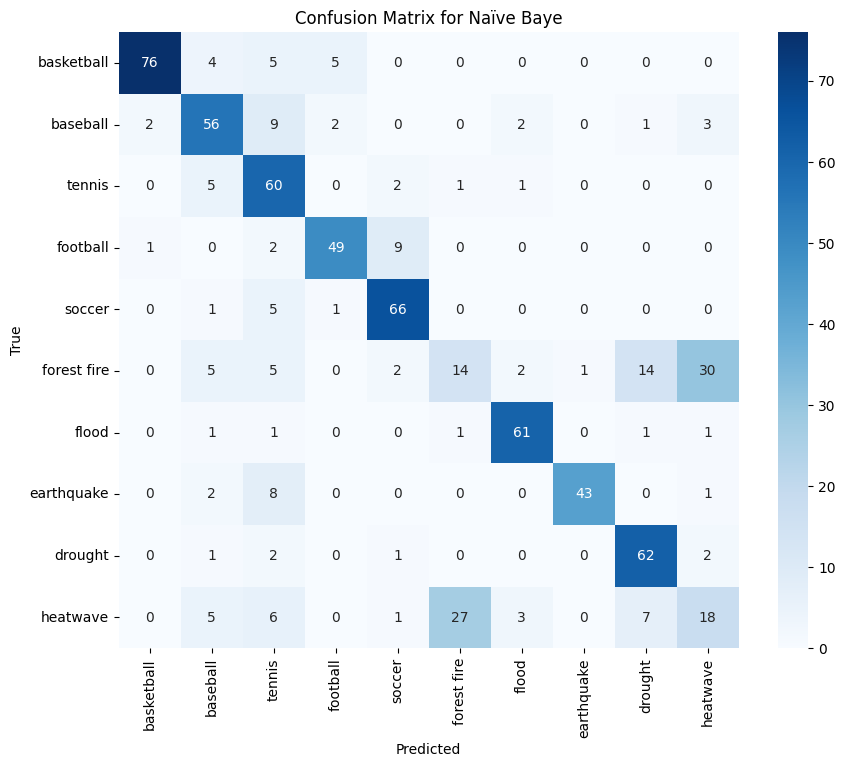

In [54]:
evaluate_multiclass_classifier(clf_nb_mc_pred, "Naïve Baye")

Accuracy for  SVM (One VS One) : 0.7873563218390804
Recall for  SVM (One VS One) : 0.7873563218390804
Precision for  SVM (One VS One) : 0.7991322250337578
F-1 Score for  SVM (One VS One) : 0.7917199053084574


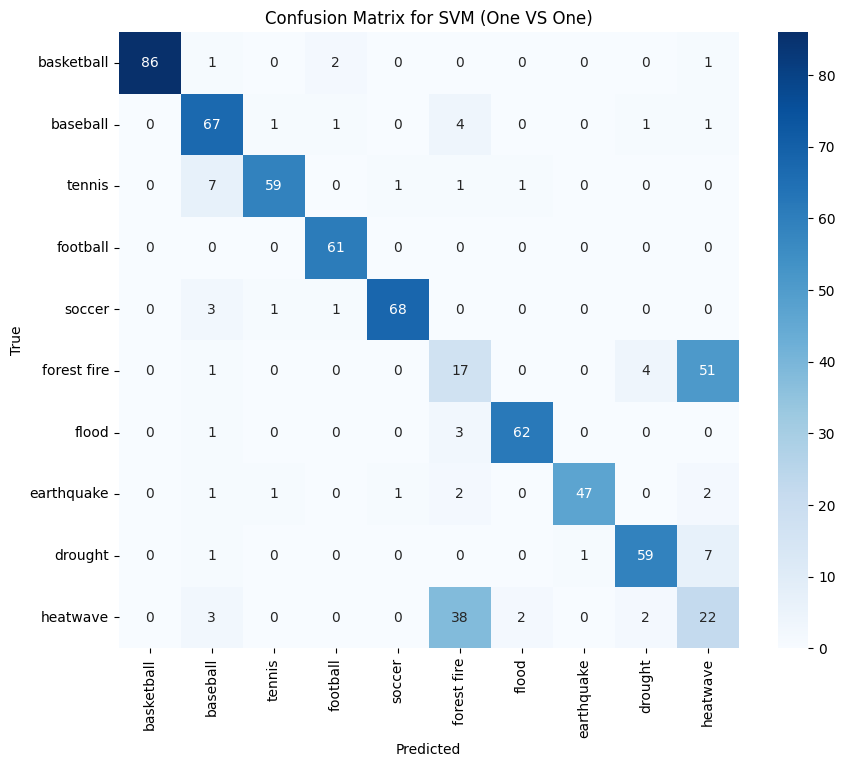

In [55]:
evaluate_multiclass_classifier(clf_svm_ovo_mc_pred, "SVM (One VS One)")

Accuracy for  SVM (One VS Rest) : 0.7902298850574713
Recall for  SVM (One VS Rest) : 0.7902298850574713
Precision for  SVM (One VS Rest) : 0.7800206386754247
F-1 Score for  SVM (One VS Rest) : 0.7834679965607194


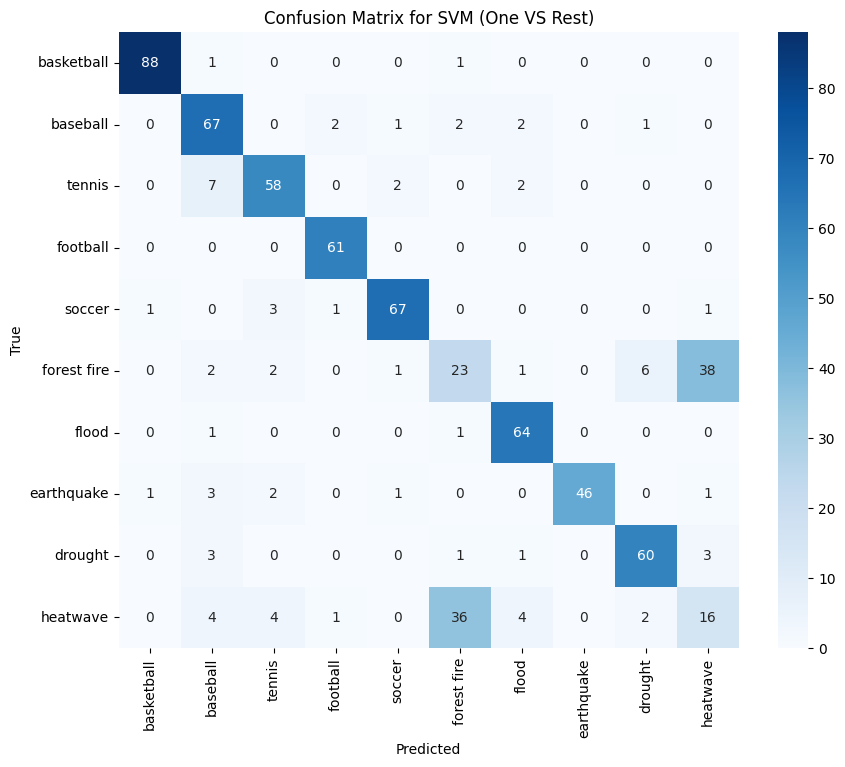

In [56]:
evaluate_multiclass_classifier(clf_svm_ovr_mc_pred, "SVM (One VS Rest)")

Q9-1: Do you observe any structure in the confusion matrix? Are there distinct visible blocks on the major diagonal? What does this mean?

- Answer:
<br>The metrices display a visible block structure, with higher values forming a diagonal-like pattern This means that most of the classifications are correct. The higher the values along the diagonal, the better the model's performance in the classification task. Conversely, values off the diagonal imply instances of misclassification between different classes.


Q9-2: Based on your observation from the previous part, suggest a subset of labels that should be merged into a new larger label and recompute the accuracy and plot the confusion matrix.

Answer:

To enhance the performance of these classification models, merging classes that exhibit frequent misclassifications is a potential strategy. By analyzing the confusion matrices, it is observed that the classes 'forest fire' and 'heatwave' are commonly misclassified as each other. Therefore, merging these two classes is suggested to address this recurring confusion.

How did the accuracy change in One VS One and One VS the rest?

Answer:

Here's the change in One VS One and One VS the rest:
- Accuracy for SVM (One VS One) before merging: **0.7873563218390804**
- Accuracy for SVM (One VS One) after merging: **0.9109195402298851**
- Accuracy for SVM (One VS Rest) before merging: **0.7902298850574713**
- Accuracy for SVM (One VS Rest) after merging: **0.9008620689655172**

The accuracy for both One VS One and One VS the Rest have significantly improved after merging the classes 'forest fire' and 'heatwave'. This improvement suggest that merging these two classes resulted in better performance.

The code for this part is shown below.

In [57]:
merged_train_y = train['leaf_label'].replace({'forest fire': 'merged_class', 'heatwave': 'merged_class'})
merged_test_y = test['leaf_label'].replace({'forest fire': 'merged_class', 'heatwave': 'merged_class'})

In [58]:
# Naïve Bayes Muticlass Classification
clf_nb_mc_merged = GaussianNB()
clf_nb_mc_merged.fit(X_train_reduced, merged_train_y)
clf_nb_mc_pred_merged = clf_nb_mc_merged.predict(test_data_LSI)

# SVM Muticlass Classification (One VS One)
params = {'estimator__C': [0.001,0.01,0.1,1,10,100,1000,10000,100000,1000000]}
svm_ovo_mc_merged = OneVsOneClassifier(LinearSVC(random_state=42))
clf_svm_ovo_mc_merged = GridSearchCV(svm_ovo_mc_merged, params, cv=5, scoring='accuracy')
clf_svm_ovo_mc_merged.fit(X_train_reduced, merged_train_y)
clf_svm_ovo_mc_pred_merged = clf_svm_ovo_mc_merged.predict(test_data_LSI)

# SVM Muticlass Classification (One VS Rest)
svm_ovr_mc_merged = OneVsRestClassifier(LinearSVC(random_state=42))
clf_svm_ovr_mc_merged = GridSearchCV(svm_ovr_mc_merged, params, cv=5, scoring='accuracy')
clf_svm_ovr_mc_merged.fit(X_train_reduced, merged_train_y)
clf_svm_ovr_mc_pred_merged = clf_svm_ovr_mc_merged.best_estimator_.predict(test_data_LSI)

classes = ["basketball", "baseball", "tennis", "football", "soccer", "merged_class", "flood", "earthquake", "drought"]

def evaluate_multiclass_classifier_merged(predicts, method_name):

  # evaluation
  print("Accuracy for ", method_name, ":", accuracy_score(merged_test_y, predicts))
  print("Recall for ", method_name, ":", recall_score(merged_test_y, predicts, average='weighted'))
  print("Precision for ", method_name, ":", precision_score(merged_test_y, predicts, average='weighted'))
  print("F-1 Score for ", method_name, ":", f1_score(merged_test_y, predicts, average='weighted'))

  # plot confusion matrix
  matrix = confusion_matrix(merged_test_y, predicts, labels = classes)
  plt.figure(figsize=(10, 8))
  sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues', xticklabels=classes , yticklabels=classes )
  plt.title(f"Confusion Matrix for {method_name}")
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()

Accuracy for  Naïve Bayes : 0.8089080459770115
Recall for  Naïve Bayes : 0.8089080459770115
Precision for  Naïve Bayes : 0.8301748681911373
F-1 Score for  Naïve Bayes : 0.811455827249759


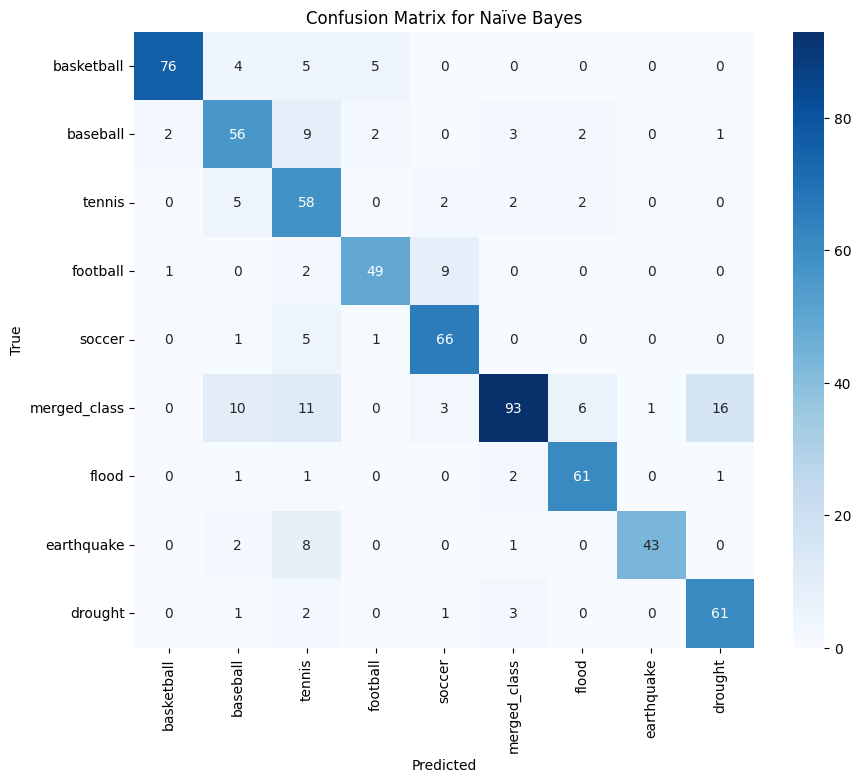

In [59]:
evaluate_multiclass_classifier_merged(clf_nb_mc_pred_merged, "Naïve Bayes")

Accuracy for  SVM (One VS One) : 0.9109195402298851
Recall for  SVM (One VS One) : 0.9109195402298851
Precision for  SVM (One VS One) : 0.9173989120096039
F-1 Score for  SVM (One VS One) : 0.9117573163336252


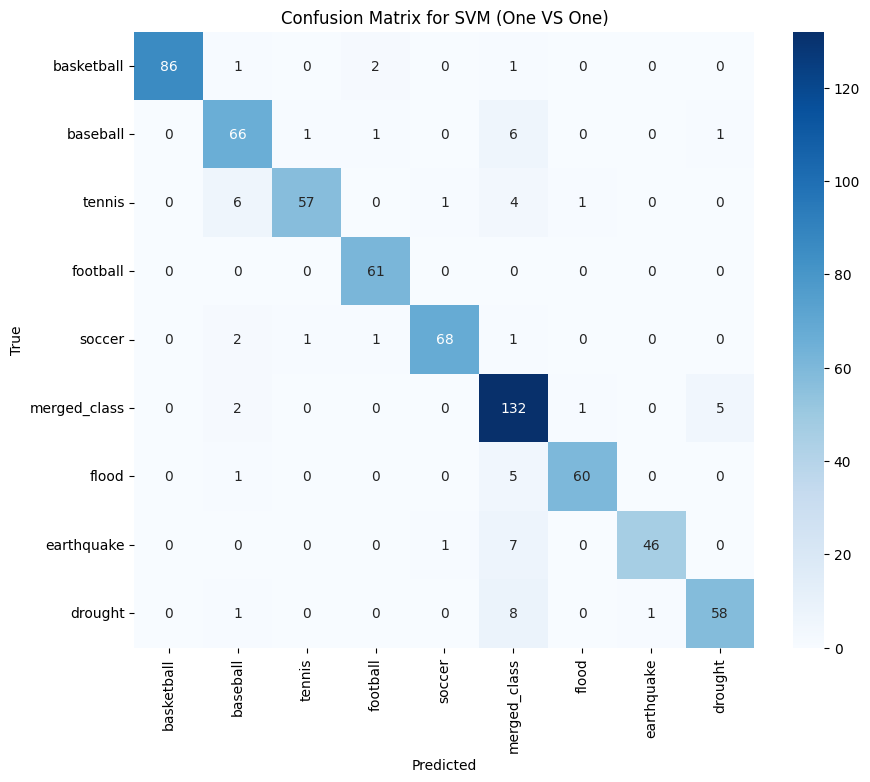

In [60]:
evaluate_multiclass_classifier_merged(clf_svm_ovo_mc_pred_merged, "SVM (One VS One)")

Accuracy for  SVM (One VS Rest) : 0.9008620689655172
Recall for  SVM (One VS Rest) : 0.9008620689655172
Precision for  SVM (One VS Rest) : 0.9059285184086303
F-1 Score for  SVM (One VS Rest) : 0.9015950494905365


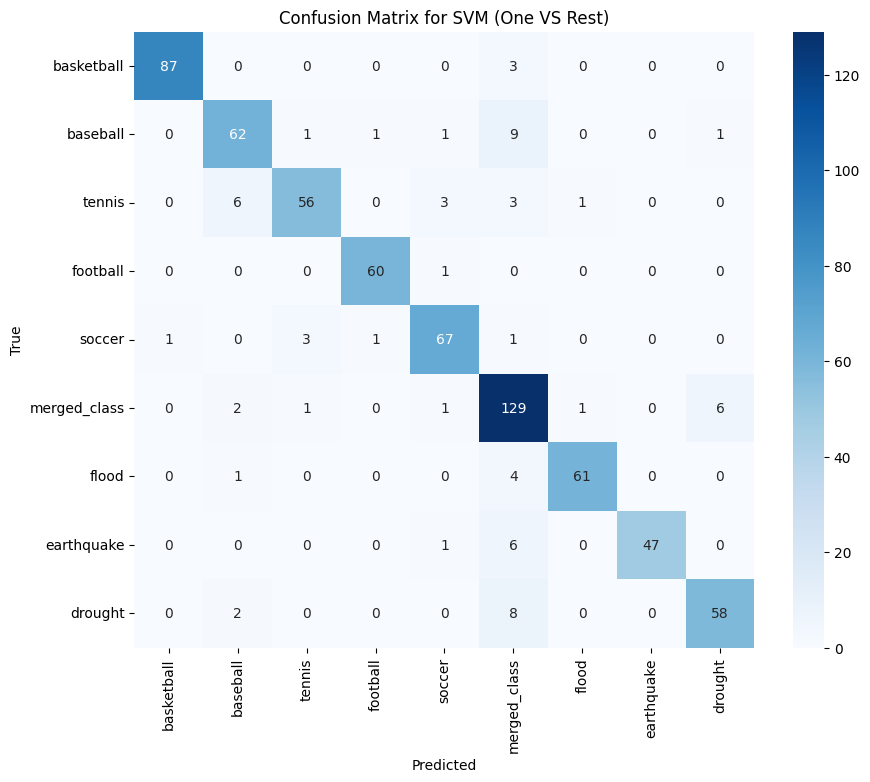

In [61]:
evaluate_multiclass_classifier_merged(clf_svm_ovr_mc_pred_merged, "SVM (One VS Rest)")

Q9-3: Does class imbalance impact the performance of the classification once some classes are merged? Provide a resolution for the class imbalance and recompute the accuracy and plot the confusion matrix in One VS One and One VS the rest.

Answer:

By plotting the classes distribution, we observed that the 'merge_class' have more instances compared to other classes causing class imbalance, indicating a class imbalance issue. To address this imbalance, we opted for oversampling as a strategy to balance the class distribution.

Here's the change in "One VS One" and "One VS Rest" before and after oversampling:
  
- Accuracy for SVM (One VS One) before oversampling: **0.9109195402298851**
- Accuracy for SVM (One VS One) after oversampling: **0.9066091954022989**
- Accuracy for SVM (One VS Rest) before oversampling: **0.9008620689655172**
- Accuracy for SVM (One VS Rest) after oversampling: **0.8994252873563219**

  The accuracy metrics and corresponding confusion matrices demonstrate a very small difference in accuracy between models trained with and without oversampling. The features in the merged dataset may provide sufficient discriminatory information for the classifier, reducing the impact of class imbalance.

The code for this part is shown below.

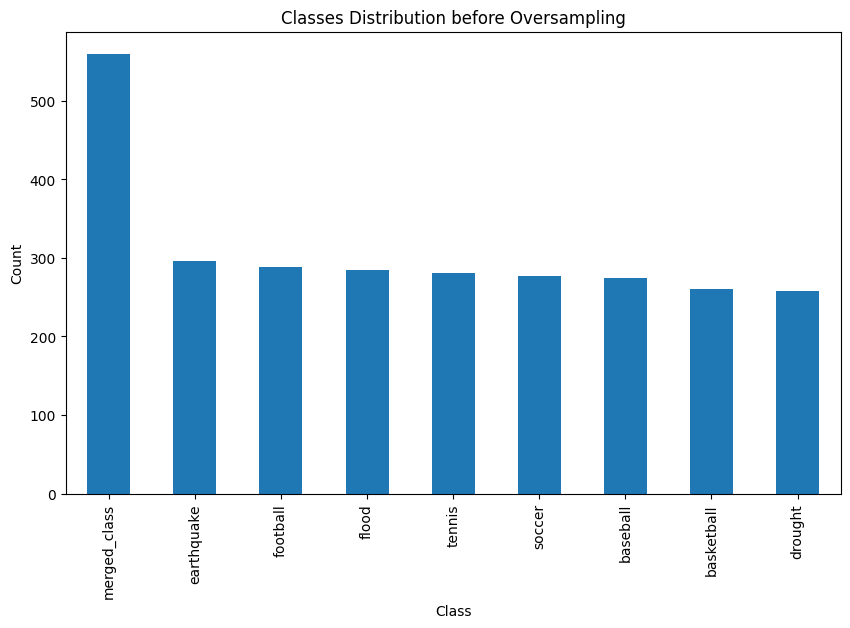

In [62]:
# Plot Classes Distribution before Oversampling
plt.figure(figsize=(10, 6))
merged_train_y.value_counts().plot(kind='bar')
plt.title('Classes Distribution before Oversampling')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

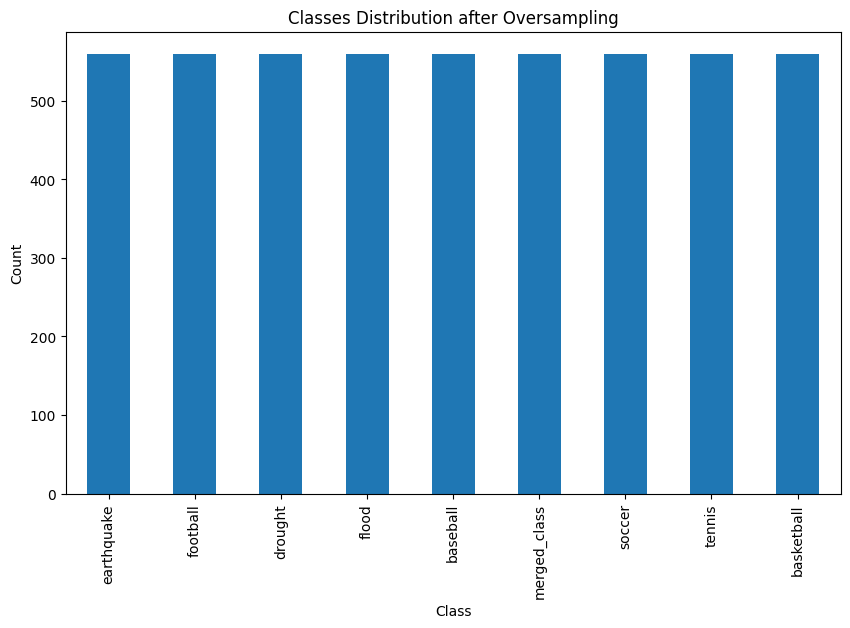

In [63]:
from imblearn.over_sampling import RandomOverSampler

oversampler = RandomOverSampler(random_state=42)

x_resampled, y_resampled = oversampler.fit_resample(X_train_reduced, merged_train_y)

# Plot Classes Distribution after Oversampling
plt.figure(figsize=(10, 6))
y_resampled.value_counts().plot(kind='bar')
plt.title('Classes Distribution after Oversampling')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [64]:
%%capture

# SVM Muticlass Classification (One VS One)
params = {'estimator__C': [0.001,0.01,0.1,1,10,100,1000,10000,100000,1000000]}
svm_ovo_resampled = OneVsOneClassifier(LinearSVC(random_state=42))
clf_ovo_resampled = GridSearchCV(svm_ovo_resampled, params, cv=5, scoring='accuracy')
clf_ovo_resampled.fit(x_resampled, y_resampled)
clf_ovo_resampled_pred = clf_ovo_resampled.predict(test_data_LSI)

# SVM Muticlass Classification (One VS Rest)
svm_ovr_resampled = OneVsRestClassifier(LinearSVC(random_state=42))
clf_ovr_resampled = GridSearchCV(svm_ovr_resampled, params, cv=5, scoring='accuracy')
clf_ovr_resampled.fit(x_resampled, y_resampled)
clf_ovr_resampled_pred  = clf_ovr_resampled.best_estimator_.predict(test_data_LSI)


Accuracy for  SVM (One VS Rest) : 0.8994252873563219
Recall for  SVM (One VS Rest) : 0.8994252873563219
Precision for  SVM (One VS Rest) : 0.9011639852052432
F-1 Score for  SVM (One VS Rest) : 0.8996291066076283


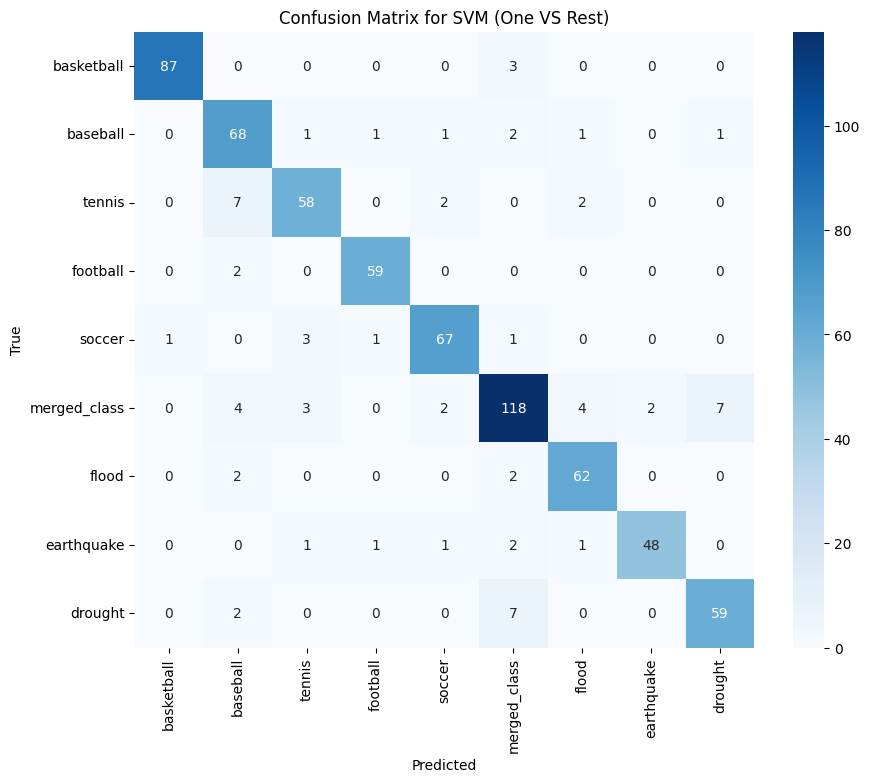

In [67]:
evaluate_multiclass_classifier_merged(clf_ovr_resampled_pred, "SVM (One VS Rest)")

Accuracy for  SVM (One VS One) : 0.9066091954022989
Recall for  SVM (One VS One) : 0.9066091954022989
Precision for  SVM (One VS One) : 0.9082270731252745
F-1 Score for  SVM (One VS One) : 0.9070056182537901


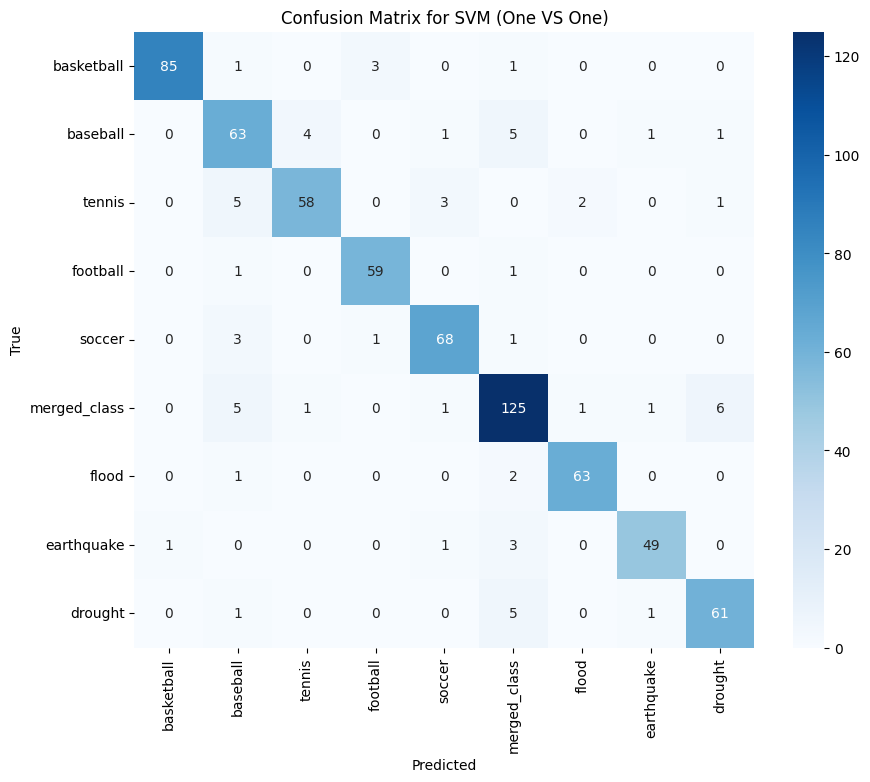

In [68]:
evaluate_multiclass_classifier_merged(clf_ovo_resampled_pred, "SVM (One VS One)")

# 7. Word Embedding

## Question 10

Read the paper about GLoVE embeddings - found here and answer the following subquestions:

### (a) Why are GLoVE embeddings trained on the ratio of co-occurrence probabilities rather than the probabilities themselves?
Answer: Because compared to the raw probabilities, the ratio of co-occurrence probabilities can better distinguish relevant words from irrelevant words. And it can better discriminate between the two relevant words.

### (b) In the two sentences: “James is running in the park.” and “James is running for the presidency.”, would GLoVE embeddings return the same vector for the word running in both cases? Why or why not?
Answer: GLoVE embeddings will return the same vector for the word running in both cases. Because GLoVE embeddings generate a single embedding for a word only based on its appearance in the training corpus, instead of generating several embeddings for a word under different contexts.

### (c) Compare these values.
Answer: Considering the semantic difference between these words, we have
$\| \text{GLoVE}["\text{wife}"] - \text{GLoVE}["\text{husband}"] \|_2 \lt \| \text{GLoVE}["\text{woman}"] - \text{GLoVE}["\text{man}"] \|_2 \lt \| \text{GLoVE}["\text{wife}"] - \text{GLoVE}["\text{orange}"] \|_2$

### (d) Given a word, would you rather stem or lemmatize the word before mapping it to its GLoVE embedding?
Answer: No. GLoVE represents multiple morphological inflections of a word(lemma), so we don't need to stem or lemmatize it before mapping to GLoVE embedding.


In [ ]:
%%script bash --out null

# Download GLoVE pretrained weights
if [[ ! -e glove.6B.zip ]]; then
  wget -O glove.6B.zip https://nlp.stanford.edu/data/glove.6B.zip
  unzip glove.6B.zip
else
  echo 'glove.6B.zip already exists!'
fi

pip install umap-learn umap-learn[plot]

## Question 11
For the binary classification task distinguishing the “sports” class and “climate” class:

### (a) Describe a feature engineering process that uses GLoVE word embeddings to represent each document.
Answer:
1. Tokenize input document(consists of one or more sentences) into word tokens $\{t_i\}$.
2. For each token $t_i$, find its embedding vector $x_i$ from the embedding dict.
3. Normalize each embedding vector to get $x'_{ij} = \frac{x_{ij}}{\text{max}(|x_{ik}|)}$.
4. Get the embedding vector of the entire document by averaging the embedding vectors of all the tokens: $x_{doc} = \text{average}(x_i)$.
5. Performance classification on this $x_{doc}$ embedding vector.

### (b) Select a classifier model, train and evaluate it with your GLoVE-based feature. If you are doing any cross-validation, please make sure to use a limited set of options so that your code finishes running in a reasonable amount of time.
Answer:
We got **accuracy = 94.54%** using a LogisticRegression model with dimension of embedding vector = 300.

The code is shown below:


In [ ]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import numpy as np
from scipy import spatial
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

import pandas as pd
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import multiprocessing as mp
from functools import partial
from typing import Optional

stop_words = set(stopwords.words('english'))

# read pretrained glove embeddings
def load_glove_weights(dimension_of_glove: int) -> dict[str, np.ndarray]:
  embeddings_dict: dict[str, np.ndarray] = {} # shape: (dims, )
  with open(f"glove.6B.{dimension_of_glove}d.txt", 'r') as f:
    for line in f:
      values = line.split()
      word = values[0]
      vector = np.asarray(values[1:], "float32")
      embeddings_dict[word] = vector
  return embeddings_dict

def get_similarity(embeddings_dict, word1: str, word2: str) -> float:
  return spatial.distance.euclidean(embeddings_dict[word1], embeddings_dict[word2])

def tokenize(sentences: str):
  words = []
  for sent in nltk.sent_tokenize(sentences):
    words += [w for w in nltk.word_tokenize(sent) if w not in stop_words]

  return words

def all_tokenize(corpus: list[str]):
  results = []
  for sentences in corpus:
    results.append(tokenize(sentences))

  return results

def embed(embeddings_dict: dict[str, np.ndarray], words: list[str]):
  embeddings = []
  for w in words:
    if w in embeddings_dict:
      vec = embeddings_dict[w]
      embeddings.append(vec / np.max(np.abs(vec)))
  return np.mean(embeddings, axis=0)

def tokenize_and_embed(embeddings_dict: dict[str, np.ndarray], text: str):
  return embed(embeddings_dict, tokenize(text))

def load_and_classify(dimension_of_glove: int, train_test_indices: Optional[list[list[int]]] = None):
  embeddings_dict = load_glove_weights(dimension_of_glove)

  # Load dataset again since it's modifided before
  df = pd.read_csv('Project1-ClassificationDataset.csv', sep=',')
  df['full_text'] = df['full_text'].map(clean)
  full_text: list[str] = df['full_text'].tolist()
  root_label: list[str] = df['root_label'].tolist()
  keywords: list[str] = df['keywords'].tolist()

  func = partial(tokenize_and_embed, embeddings_dict)
  with mp.Pool(mp.cpu_count()) as p:
    embeddings = p.map(func, full_text)

  if train_test_indices is not None:
    embeddings_train = [embeddings[i] for i in train_test_indices[0]]
    embeddings_test = [embeddings[i] for i in train_test_indices[1]]
    root_label_train = [root_label[i] for i in train_test_indices[0]]
    root_label_test = [root_label[i] for i in train_test_indices[1]]
  else:
    embeddings_train, embeddings_test, root_label_train, root_label_test = train_test_split(embeddings, root_label, test_size=0.2)

  # Classification
  clf = make_pipeline(StandardScaler(), LogisticRegression(penalty='l2'))
  clf.fit(embeddings_train, root_label_train)

  cls_score = clf.score(embeddings_test, root_label_test)
  return cls_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
score = load_and_classify(300)
print(f'clf score for dim 300: {score}')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


clf score for dim 300: 0.9540229885057471


## Question 12

Plot the relationship between the dimension of the pre-trained GLoVE embedding and the resulting accuracy of the model in the classification task. Describe the observed trend. Is this trend expected? Why or why not? In this part use the different sets of GLoVE vectors from the link.

### Answer

The figure of the relationship between the dimension of the pre-trained GLoVE embedding and the resulting accuracy of the model in the classification task is shown below.

We can see that as the dimension of embedding vector increases from 50 to 300, the accuracy approximately keeps increasing, which meets the expectation, because the embedding vector becomes more informative.

clf score for dim 50: 0.9264041316978696


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


clf score for dim 100: 0.9354422207876049


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


clf score for dim 200: 0.9309231762427372


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


clf score for dim 300: 0.94770819883796


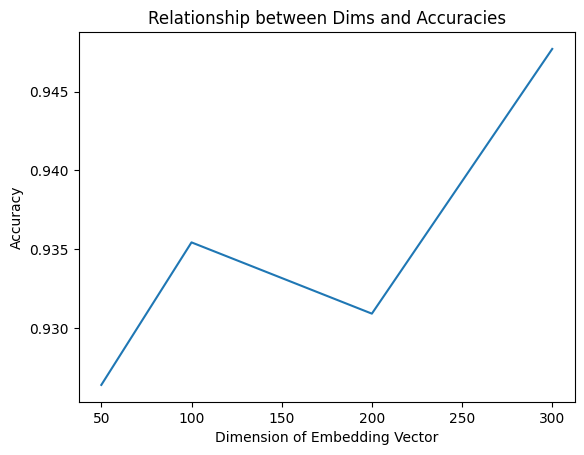

In [ ]:
# Code for Q12
import random

dims = [50, 100, 200, 300]
cls_scores = []

df = pd.read_csv('Project1-ClassificationDataset.csv', sep=',')
full_text: list[str] = df['full_text'].tolist()
num_samples = len(full_text)

train_indices = random.choices(list(range(num_samples)), k=int(num_samples * 0.8))
train_indices_set = set(train_indices)
test_indices = [x for x in range(num_samples) if x not in train_indices_set]

train_test_indices = [train_indices, test_indices]

for dimension_of_glove in dims:
  score = load_and_classify(dimension_of_glove, train_test_indices)
  print(f'clf score for dim {dimension_of_glove}: {score}')
  cls_scores.append(score)

# Plot Relationship for Q12
plt.plot(dims, cls_scores)
plt.title('Relationship between Dims and Accuracies')
plt.xlabel('Dimension of Embedding Vector')
plt.ylabel('Accuracy')
plt.show()

## Question 13

Compare and contrast the two visualizations. Are there clusters formed in either or both of the plots? We will pursue the clustering aspect further in the next project.

### Answer

As you can see, the GLoVE embeddings of the same class stay close to each other while those of different classes keep distances. On the other hand, the randomly generated embeddings(or just vectors) randomly distributed in the space.

The visualizations are shown below.


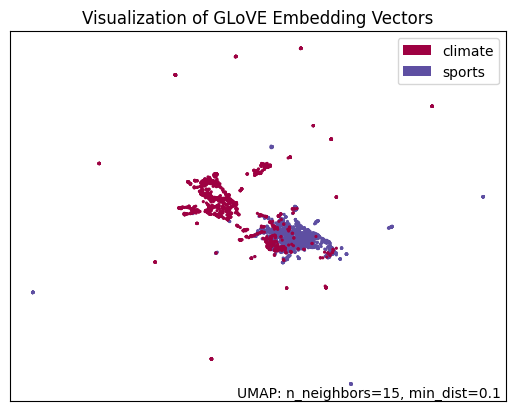

In [ ]:
# Code for Q13

import umap
import umap.plot

dimension_of_glove = 300
embeddings_dict = load_glove_weights(dimension_of_glove)

# Load dataset again since it's modifided before
df = pd.read_csv('Project1-ClassificationDataset.csv', sep=',')
df['full_text'] = df['full_text'].map(clean)
full_text: list[str] = df['full_text'].tolist()
root_label: list[str] = df['root_label'].tolist()

num_samples = len(full_text)

func = partial(tokenize_and_embed, embeddings_dict)
with mp.Pool(mp.cpu_count()) as p:
  embeddings = p.map(func, full_text)

embeddings_reduced = umap.UMAP(n_components=2, metric='euclidean').fit(embeddings)
# embeddings_reduced = umap.UMAP(n_components=2, metric='hellinger').fit(embeddings)
fig, ax = plt.subplots()
ax.set_title('Visualization of GLoVE Embedding Vectors')

f = umap.plot.points(embeddings_reduced, labels=np.asarray(root_label), ax=ax)

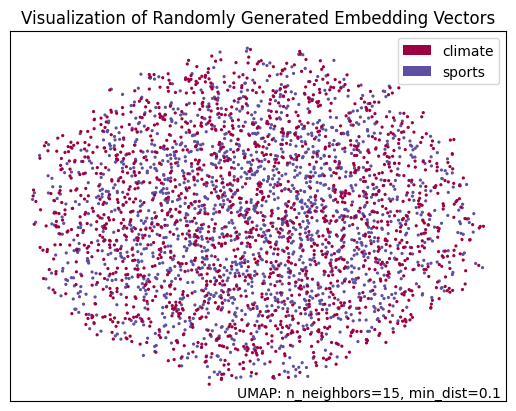

In [ ]:
random_embeddings = [np.random.normal(size=300) for _ in range(num_samples)]

fig, ax = plt.subplots()
ax.set_title('Visualization of Randomly Generated Embedding Vectors')
random_embeddings_reduced = umap.UMAP(n_components=2, metric='euclidean').fit(random_embeddings)
f = umap.plot.points(random_embeddings_reduced, labels=np.asarray(root_label), ax=ax)